# **Data Cleaning & Preparation** 

This notebook contains the code used to clean and prepare all data for the project. This includes speech data for NLP, and the economic indicators data. The preparation in this notebook also includes the generation and normalisation of sentiment scores through NLP such that the resulting data files are ready for instant analysis by the team. Code is split into two sections to preserve the narative of the project, before our first presentation with BoE (10/4/24) and after. 

The notebook has the following structure:

    - Cleaning of Speech Data
    - NLP of Speech Data
    - Cleaning of Economic Idicator Data

## Library Installation and Imports

In [1]:
# Install the necessary libraries. (You will need to run these if not already on your system)
'''
!pip install nltk
!pip install vaderSentiment
!pip install textblob
!pip install selenium
!pip install webdriver_manager
!pip install PyMuPDF
!pip install transformers
!pip install torch torchvision torchaudio
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
'''


# Import the necessary libraries.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
stop_words = set(stopwords.words('english'))
from transformers import BertTokenizer, BertForSequenceClassification
import torch

from selenium import webdriver # initiate and interact with browser session
from selenium.webdriver.chrome.service import Service # control chromedriver
from selenium.webdriver.chrome.options import Options # other settings e.g. 'headless'
from selenium.webdriver.common.by import By # select elements by their attribute (CSS_SELECTOR)
from selenium.webdriver.support.ui import WebDriverWait # wait for certain conditions to load
from selenium.webdriver.support import expected_conditions as EC # links with webdriverwait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
import requests # Allows the script to send HTTP requests to download web content
import fitz  # PyMuPDF for handling PDFs
import pandas as pd # dataframe operations, CSV export
from bs4 import BeautifulSoup # For parsing HTML content
from io import BytesIO # Handles byte streams (used in the script for reading PDF content in memory)
from selenium.common.exceptions import TimeoutException # if webdriverwait is not effective
import time # delay processes to replicate human speed to avoid crashing servers and count the length of scrape
from datetime import datetime # record the datetime of scraping
import re # text
import os
from IPython.display import Image

# Cleaning of Speech Data

In [2]:
# Load dataset
unclean_speeches = pd.read_csv('all_speeches.csv')
print(unclean_speeches.head())
print('Shape: ', unclean_speeches.shape)

      reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...  
Shape:  (7721, 7)


The data set has 7 columns and 7721 records.

### Exploration

In [3]:
print('Speeches by Country:\n--------------------\n', unclean_speeches.country.value_counts())
print('\nSpeeches by Author:\n-------------------\n', unclean_speeches.author.value_counts())

Speeches by Country:
--------------------
 euro area         2351
united states     1551
united kingdom    1209
japan              755
canada             620
sweden             600
switzerland        351
australia          284
Name: country, dtype: int64

Speeches by Author:
-------------------
 no_info       342
trichet       272
bernanke      209
coeure        174
carney        167
             ... 
young           1
aires           1
jackson         1
bratislava      1
cook            1
Name: author, Length: 325, dtype: int64


Inspecting the counts of countries and authors, there are no nonsensical countries. There are 'no_info' entries where author is not known, these will be changed to NaN and should be kept in mind later in the analysis. they will not be dropped as author is not essential. Below I will change 'euro area' entries to 'european', as well as further inspect authors with only one count:

In [4]:
# Further inspect aurthors with only one count.
print(unclean_speeches[unclean_speeches['author'].map(unclean_speeches['author'].value_counts()) == 1])

# Change 'euro area' entries to 'european'.
unclean_speeches['country'] = unclean_speeches['country'].replace('euro area', 'european')
# Check change.
print('Speeches by Country:\n--------------------\n', unclean_speeches.country.value_counts())

          reference         country        date  \
207    r160810a_BOA       australia  2016-08-10   
295    r980611a_BOC          canada  1998-06-11   
541    r100111a_BOC          canada  2010-01-11   
665    r140402a_BOC          canada  2014-04-02   
688    r150217a_BOC          canada  2015-02-17   
...             ...             ...         ...   
6158   r220907a_BOE  united kingdom  2022-09-07   
6565  r030620a_FOMC   united states  2003-06-20   
7028  r090821a_FOMC   united states  2009-08-21   
7713  r221004a_FOMC   united states  2022-10-04   
7714  r221006b_FOMC   united states  2022-10-06   

                                                  title     author  is_gov  \
207                                                             ac       0   
295   The outlook for the Canadian economy and monet...      bonin       0   
541   Canada's Housing Sector in Recession and Recov...       wolf       0   
665                      Briefing on Digital Currencies    johnson       0 

Next to perform null, type and length checks on data.

In [5]:
# Null/Na check on every column.
print("Null check on every column:\n--------------------------\n", unclean_speeches.isnull().sum())
print("\nNa check on every column:\n--------------------------\n", unclean_speeches.isna().sum())

# Type check on every column.
print("\nType check on every column:\n-------------------------\n", unclean_speeches.dtypes, "\n")
# Change data column from object to datetime64 data type.
unclean_speeches['date'] = pd.to_datetime(unclean_speeches['date'])
# Change the 'is_gov' column to boolean type
unclean_speeches['is_gov'] = unclean_speeches['is_gov'].astype(bool)
# Check date data. 
print(unclean_speeches['is_gov'].unique())
print(unclean_speeches[['date','is_gov']].head())

# Create length column for speech length.
unclean_speeches['length'] = unclean_speeches['text'].str.len()
# Check length column
print(unclean_speeches[['text', 'length']].head())
# Print speeches shorter than 200 characters.
print("\nLength check on the 'text' column:", 
      unclean_speeches.loc[unclean_speeches['length'] < 200, ['text','length']])
# Drop outlying short speeches.
clean_speeches = unclean_speeches.drop(unclean_speeches.loc[unclean_speeches['length'] < 200].index)
# Check dropped correctly.
print("\nShort speeches in clean column:", 
      clean_speeches.loc[unclean_speeches['length'] < 200, ['text','length']])

# Reindex the DataFrame
clean_speeches.reset_index(drop=True, inplace=True)

Null check on every column:
--------------------------
 reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

Na check on every column:
--------------------------
 reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

Type check on every column:
-------------------------
 reference    object
country      object
date         object
title        object
author       object
is_gov        int64
text         object
dtype: object 

[False  True]
        date  is_gov
0 1990-11-28   False
1 1991-10-03   False
2 1992-03-14   False
3 1992-05-29   False
4 1992-08-17   False
                                                text  length
0  They would no doubt argue that to have two obj...   21288
1  Today I wish to talk about real interest rates...   18838
2  I welcome this opportunity to talk about prosp...   21100
3  It is a pleasure to have this opportunity to a...   23

 - The data contains no null/na values. 
 - The data type of dates was changed to datetime64 for efficiency and improved functionality/manipulation. All other columns were apropriate data types.
 - A length check highlighted a significantly short speech at 131 characters which was removed.
 - is_gov was changed to boolean datatype.
 
 Below titles are checked:

In [6]:
# Filter records where the 'title' column is blank or contains only whitespace characters
print('Blank titles:\n', clean_speeches[clean_speeches['title'].str.strip() == ''])

# Replace blank titles or titles containing only whitespace characters with 'no_info'
clean_speeches.loc[clean_speeches['title'].str.strip() == '', 'title'] = 'no_info'
# Print the DataFrame to verify the changes
print(clean_speeches)

Blank titles:
           reference        country       date     title    author  is_gov  \
1      r911003a_BOA      australia 1991-10-03              fraser   False   
2      r920314a_BOA      australia 1992-03-14              fraser   False   
3      r920529a_BOA      australia 1992-05-29              fraser   False   
4      r920817a_BOA      australia 1992-08-17              fraser   False   
5      r930331a_BOA      australia 1993-03-31              fraser   False   
...             ...            ...        ...       ...       ...     ...   
213    r170224a_BOA      australia 2017-02-24                lowe    True   
218    r170811a_BOA      australia 2017-08-11                lowe    True   
6469  r020307a_FOMC  united states 2002-03-07            gramlich   False   
6511  r021108a_FOMC  united states 2002-11-08            bernanke    True   
6588  r031113a_FOMC  united states 2003-11-13            ferguson   False   

                                                   text  len

Many blank titles were found. These were changes to 'no_info' inline with the way null data has been captured for authors. This highlighted that the null/na checks above were not sufficient, we will reperform these checks using the code above.

In [7]:
# Checking titles shorter than 4 characters.
print(clean_speeches[clean_speeches['title'].str.len() < 4].count())
print(clean_speeches[clean_speeches['title'].str.len() < 4])

reference    8
country      8
date         8
title        8
author       8
is_gov       8
text         8
length       8
dtype: int64
          reference         country       date title     author  is_gov  \
5344   r100312a_BOE  united kingdom 2010-03-12    QE       dale   False   
6175  r970214a_FOMC   united states 1997-02-14   one   phillips   False   
6179  r970313a_FOMC   united states 1997-03-13    we     rivlin   False   
6293  r990416a_FOMC   united states 1999-04-16   for  greenspan    True   
6576  r031001a_FOMC   united states 2003-10-01    de   gramlich   False   
6627  r040401a_FOMC   united states 2004-04-01   not       kohn   False   
6635  r040423b_FOMC   united states 2004-04-23    ,    ferguson   False   
6681  r041015a_FOMC   united states 2004-10-15   Oil    no_info   False   

                                                   text  length  
5344  This has been a truly extraordinary year for o...   26023  
6175  It is a great pleasure to have the opportunity...   2

This highlighted records with nonsensicle one word titles, this is presumably an issue introduced because the data was sourced through web-scraping. These records will be kept because the title has no impact on the speech. Use of titles such as 'Oil' may be significant in analysing topic frequency, so these entries shall be kept, but it is noted by the analytics team that the data quality of titles is poor. The column will remain in order to reference speeches of significace later in analysis should the quality of data in such specific cases allow.

In [8]:
# Checks for Null values in textual data 
print('reference:', clean_speeches[clean_speeches['reference'].str.strip() == ''])
print('country:', clean_speeches[clean_speeches['country'].str.strip() == ''])
print('title:', clean_speeches[clean_speeches['title'].str.strip() == ''])
print('author:', clean_speeches[clean_speeches['author'].str.strip() == ''])
print('text:', clean_speeches[clean_speeches['text'].str.strip() == ''])

reference: Empty DataFrame
Columns: [reference, country, date, title, author, is_gov, text, length]
Index: []
country: Empty DataFrame
Columns: [reference, country, date, title, author, is_gov, text, length]
Index: []
title: Empty DataFrame
Columns: [reference, country, date, title, author, is_gov, text, length]
Index: []
author: Empty DataFrame
Columns: [reference, country, date, title, author, is_gov, text, length]
Index: []
text: Empty DataFrame
Columns: [reference, country, date, title, author, is_gov, text, length]
Index: []


This shows there are no further blank entries to handle.

### Check for Duplicates

In [9]:
# Find duplicate rows based on 'text' column (keeping the first occurrence)
duplicate_rows = clean_speeches[clean_speeches.duplicated(subset=['text'], keep=False)].sort_values(by=['text'])

# Print number of duplicates.
print(duplicate_rows.count())

# Print duplicates
duplicate_rows.head(10)

reference    57
country      57
date         57
title        57
author       57
is_gov       57
text         57
length       57
dtype: int64


,reference,country,date,title,author,is_gov,text,length
2823,r180507a_ECB,european,2018-05-07,Economic developments in the euro area,praet,False,After several quarters of higher than expected...,13912
2828,r180514c_ECB,european,2018-05-14,Economic developments in the euro area,praet,False,After several quarters of higher than expected...,13912
6704,r050224a_FOMC,united states,2005-02-24,Presented at the University of Arkansas at Lit...,bernanke,True,"Almost certainly, the most important economic ...",29099
6698,r050119a_FOMC,united states,2005-01-19,Presented at the University of Arkansas at Lit...,bernanke,True,"Almost certainly, the most important economic ...",29099
6141,r220526a_BOE,united kingdom,2022-05-26,Four Rs: Creating the conditions for long-term...,gerken,False,Asset eligibility Liability eligibility Calcul...,90583
6081,r210429b_BOE,united kingdom,2021-04-29,Developments in the PRA’s supervision of annui...,gerken,False,Asset eligibility Liability eligibility Calcul...,90583
6080,r210421a_BOE,united kingdom,2021-04-21,Opening remarks: meeting varied people,rosen,False,Bank of England's relationship with financial ...,24134
5657,r150226a_BOE,united kingdom,2015-02-26,"Goodbye ambiguity, hello clarity: the Bank of ...",shafik,False,Bank of England's relationship with financial ...,24134
6602,r040114a_FOMC,united states,2004-01-14,Presented at the Meetings of the American Econ...,reinhart,False,"Can monetary policy committees, accustomed to ...",22950
6597,r040103a_FOMC,united states,2004-01-03,Presented at the Meetings of the American Econ...,reinhart,False,"Can monetary policy committees, accustomed to ...",22950


57 duplicate rows were found, these are removed below, keeping the first intsances. Its worth noting that this introduces a data quality issue in that for example the first duplicate text has two entires with different datas. We cannot trust either of these dates. The decision was made to keep one entry with poor quality meta data as the speech sentiment itself is worth more in value than the accuracy of the metadata.

In [10]:
# Remove duplicate rows based on 'text' column (keeping the first occurrence)
clean_speeches = clean_speeches.drop_duplicates(subset=['text'])

# Re-check the number of duplicates.
duplicate_rows = clean_speeches[clean_speeches.duplicated(subset=['text'], keep=False)].sort_values(by=['text'])
print(duplicate_rows.count())

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
length       0
dtype: int64


Duplicate rows were removed succesfully. There is a number of speeches that appear to have erroneously small lengths so this is explore further below.

count      7691.000000
mean      19421.766220
std       12423.123213
min         615.000000
25%       11912.500000
50%       18178.000000
75%       24240.500000
max      239461.000000
Name: length, dtype: float64


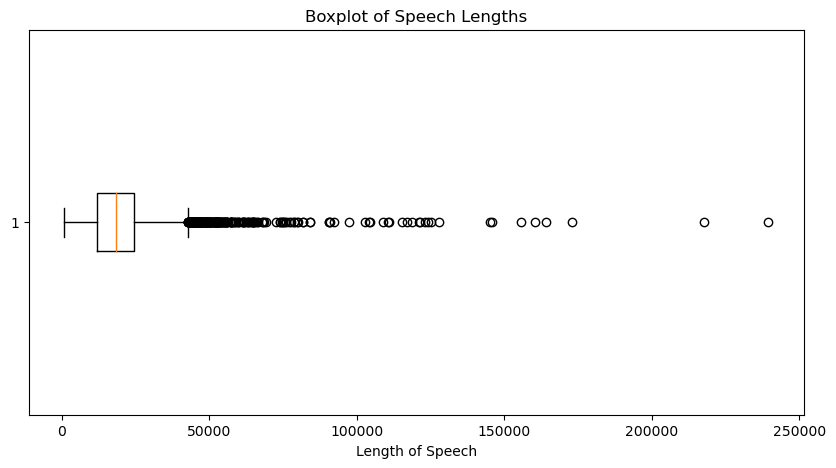

In [11]:
# Summary stats of speech length
print(clean_speeches['length'].describe())

# Creating a boxplot for the 'length' column
plt.figure(figsize=(10, 5))
plt.boxplot(clean_speeches['length'], vert=False)  # 'vert=False' makes the boxplot horizontal
# Formatting
plt.title('Boxplot of Speech Lengths')
plt.xlabel('Length of Speech')
plt.show()

Interestingly shorter speeches aren't considered outliers, examining these further:

In [12]:
# Number of speeches shorter than 3000 characters.
print(clean_speeches[clean_speeches['length'] < 1000].count())

# Details of speeches shorter than 3000 characters.
short_speeches = clean_speeches[clean_speeches['length'] < 1000]
short_speeches

reference    8
country      8
date         8
title        8
author       8
is_gov       8
text         8
length       8
dtype: int64


,reference,country,date,title,author,is_gov,text,length
1070,r000512a_ECB,european,2000-05-12,Official celebration of the 150th anniversary ...,duisenberg,True,It is a great honour to be invited to speak at...,823
1879,r090930a_ECB,european,2009-09-30,The regulatory and supervisory reform in Europe,trichet,True,It is a pleasure to be here among you and to s...,615
1917,r100211a_ECB,european,2010-02-11,Statement following the meeting of the Heads o...,no_info,False,I consider the statement of the Heads of State...,903
3089,r201217a_ECB,european,2020-12-17,NO_INFO,schnabel,False,"In the absence of policies, global warming is ...",627
3125,r210622a_ECB,european,2021-06-22,NO_INFO,lane,False,Note: Data for Ireland not included due to dat...,820
3133,r210826a_ECB,european,2021-08-26,NO_INFO,no_info,False,Note: HICPX refers to HICP excluding energy an...,990
4426,r090313a_SRB,sweden,2009-03-13,Evaluating monetary policy,svensson,False,Figure 1. Forecast errors for a number of anal...,688
6564,r030620a_FOMC,united states,2003-06-20,Abstract.,sack,False,Statements released by the Federal Open Market...,799


These appear to be a mixture of non speech text, such as a report abstract, and figure descriptions. They will be left in however as such text is difficult to filter out at scale, and the overall sentiment they contribute should still be of value as they are still relevant.

In [13]:
# Search 'title' column for entries that contain the word 'Slides', case-insensitive
title_slides = clean_speeches[clean_speeches['title'].str.contains('Slides|Summary', case=False, na=False)]

title_slides.head(10)

,reference,country,date,title,author,is_gov,text,length
1331,r040512b_ECB,european,2004-05-12,Summary of “The ECB and the euro - the first f...,issing,False,The European Central Bank (ECB) has now been c...,4938
3333,r030903a_BOJ,japan,2003-09-03,"Summary of a Speech by Toshihiko Fukui, Govern...",fukui,True,Economic activity as a whole has been flat sin...,18794
3334,r030918a_BOJ,japan,2003-09-18,"Summary of Remarks by Toshihiko Fukui, Governo...",fukui,True,"As you are aware, economic activity in Japan c...",7429
3336,r031001a_BOJ,japan,2003-10-01,"Summary of a Speech by Toshihiko Fukui, Govern...",fukui,True,Let me begin by discussing the world economy. ...,11520
3342,r031208a_BOJ,japan,2003-12-08,"Summary of a Speech given by Toshihiko Fukui, ...",fukui,True,Largely in line with the standard scenario in ...,21002
3354,r040902a_BOJ,japan,2004-09-02,"Summary of a Speech Given by Toshihiko Fukui, ...",fukui,True,Today I will discuss the economic situation at...,11688
3363,r041213a_BOJ,japan,2004-12-13,"Summary of a Speech Given by Toshihiko Fukui, ...",fukui,True,The Japanese economy has been in a recovery ph...,15847
3376,r050925a_BOJ,japan,2005-09-25,"Summary of a Speech Given by Toshihiko Fukui, ...",fukui,True,It is a pleasure to appear before you this mor...,19160
3377,r050929a_BOJ,japan,2005-09-29,"Summary of a Speech Given by Toshihiko Fukui, ...",fukui,True,Today I plan to focus on recent developments i...,12583
3382,r051208a_BOJ,japan,2005-12-08,"Summary of a Speech Given by Toshihiko Fukui, ...",fukui,True,I understand that this has been a very active ...,15942


Above we can see many 'speech' entries are in fact summarys or the text from slides used in speeches. These will be left in given that summaries are still relevent. It is worth noting that this is a limitation of the project. Summary data may introduce bias in the given sentiment scoures. This is because language for sentiments such as 'litigious' are more likely to be present in summary text than sentiments like 'positive' and 'negative' which are usually more infered from filler words stripped out for summaries.

In [14]:
# Convert to lower case and remove punctuation for speech text.
clean_speeches['text'] = clean_speeches['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
clean_speeches['text'] = clean_speeches['text'].str.replace('[^\w\s]','',regex=True)

# Apply lowercase conversion and punctuation removal to the 'title' column. Saved in new column title_nlp.
clean_speeches['title_nlp'] = clean_speeches['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
clean_speeches['title_nlp'] = clean_speeches['title_nlp'].str.replace('[^\w\s]','',regex=True)

# Check cleaning
print(clean_speeches.head())

      reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                             no_info   
2  r920314a_BOA  australia 1992-03-14                             no_info   
3  r920529a_BOA  australia 1992-05-29                             no_info   
4  r920817a_BOA  australia 1992-08-17                             no_info   

   author  is_gov                                               text  length  \
0  fraser   False  they would no doubt argue that to have two obj...   21288   
1  fraser   False  today i wish to talk about real interest rates...   18838   
2  fraser   False  i welcome this opportunity to talk about prosp...   21100   
3  fraser   False  it is a pleasure to have this opportunity to a...   23608   
4  fraser   False  as a longtime fan of don sanders i am delighte...   25337   

                           title_nlp  
0  a proper role 

### Splitting the Data - UK & Foreign
The data is split into UK speeches, and then the foreign data set. This is for efficiency because the majority of analysis will only require UK speeches.

In [15]:
# Creating UK-only dataframe from cleaned data.
uk_speeches = clean_speeches[clean_speeches['country']=='united kingdom'].sort_values('date').reset_index(drop=True)
# Drop the 'country' column
uk_speeches = uk_speeches.drop('country', axis=1)
# Display
print('UK Speeches:\n------------\n')
print(uk_speeches.shape)
print(uk_speeches.head())

# Creating foreign dataframe from cleaned data.
foreign_speeches = clean_speeches[clean_speeches['country'] != 'united kingdom']
# Display
print('\nForeign Speeches:\n-----------------\n')
print(foreign_speeches.shape)
print(foreign_speeches.head())

# Display shape of total data for checking.
print('\nTotal Speeches:\n---------------\n')
print(clean_speeches.shape)
print(clean_speeches.head())

UK Speeches:
------------

(1202, 8)
      reference       date                                              title  \
0  r980915a_BOE 1998-09-15                                             Speech   
1  r981021b_BOE 1998-10-21                                  Britain in Europe   
2  r981021a_BOE 1998-10-21  Impact of the recent turbulence in internation...   
3  r981101a_BOE 1998-11-01        Economic policy, with and without forecasts   
4  r981101b_BOE 1998-11-01  Inflation targeting in practice: the UK experi...   

    author  is_gov                                               text  length  \
0   george   False  thank you chairman im actually very pleased to...   13731   
1   george   False  its a great pleasure to be here in the beautif...   24263   
2     king    True  few industries have suffered more from volatil...   13678   
3     budd   False  my topic this evening is the use of forecasts ...   27679   
4  vickers   False  six years ago this week sterling left the exch...  

As expected there are 1209 uk speeches and 6511 foreign speeches to give a total of 7720 speeches. The country column was dropped from uk speeches as it is now redundant. Below the data is stored as csv's.

In [16]:
# Store the DataFrame as 'uk_speeches.csv'.
uk_speeches.to_csv('uk_speeches.csv', index=False)

# Store cleaned global data.
foreign_speeches.to_csv('foreign_speeches.csv', index=False)

# Preparation of text data for NLP

Above was more general data cleaning practise, below is cleaning specific to the preperation of NLP. We will store the NLP prepared title as well as the original title so that it may be used for analysis (such as wordclouds) or used for reference (i.e naming notable speeches).

In [17]:
# Load the wordlist from csv
wordlist = pd.read_csv('wordlist.csv', sep=',')
# Convert wordlist to lowercase
wordlist['Word'] = wordlist['Word'].str.lower()

# Convert the DataFrame to a dictionary
custom_wordlist = {}
for index, row in wordlist.iterrows():
    word = row['Word']
    sentiment_scores = {
        'negative': int(row['Negative']),
        'positive': int(row['Positive']),
        'uncertainty': int(row['Uncertainty']),
        'litigious': int(row['Litigious']),
        'strong': int(row['Strong']),
        'weak': int(row['Weak']),
        'constraining': int(row['Constraining'])
    }
    custom_wordlist[word] = sentiment_scores

# Define a function to score text using the custom wordlist
def custom_sentiment(text):
    total_score = {'negative': 0, 'positive': 0, 'uncertainty': 0, 'litigious': 0, 'strong': 0, 'weak': 0, 'constraining': 0}
    words = TextBlob(text).words
    for word in words:
        if word in custom_wordlist:
            word_sentiment_scores = custom_wordlist[word]
            for sentiment, score in word_sentiment_scores.items():
                total_score[sentiment] += score
    return total_score

# Define a function to calculate sentiment for each speech and return as a Series
def calculate_sentiment(speech):
    sentiment_score = custom_sentiment(speech)
    return pd.Series(sentiment_score)

# Apply the function to each speech in the DataFrame and store the results in new columns
sentiment_columns = uk_speeches['text'].apply(calculate_sentiment)

# Merge the sentiment columns with the original DataFrame
uk_speeches_sentiment = pd.concat([uk_speeches, sentiment_columns], axis=1)

# Display the DataFrame with sentiment scores
print(uk_speeches_sentiment)


         reference       date  \
0     r980915a_BOE 1998-09-15   
1     r981021b_BOE 1998-10-21   
2     r981021a_BOE 1998-10-21   
3     r981101a_BOE 1998-11-01   
4     r981101b_BOE 1998-11-01   
...            ...        ...   
1197  r221007a_BOE 2022-10-07   
1198  r221012a_BOE 2022-10-12   
1199  r221015a_BOE 2022-10-15   
1200  r221019a_BOE 2022-10-19   
1201  r221020a_BOE 2022-10-20   

                                                  title     author  is_gov  \
0                                                Speech     george   False   
1                                     Britain in Europe     george   False   
2     Impact of the recent turbulence in internation...       king    True   
3           Economic policy, with and without forecasts       budd   False   
4     Inflation targeting in practice: the UK experi...    vickers   False   
...                                                 ...        ...     ...   
1197         Shocks, inflation, and the policy response  

These sentiment scores will be skewed by the length of the speech as textblob does not take into account the length of speeches, therefore we will normalise the data by dividing sentiments by the length of the speech.

In [18]:
# Divide sentiment columns by the 'length' column to create adjusted sentiment columns
sentiment_columns_adjusted = sentiment_columns.div(uk_speeches['length'], axis=0)

# Rename the adjusted sentiment columns
sentiment_columns_adjusted.columns = [f"{col}_normalised" for col in sentiment_columns.columns]

# Merge the adjusted sentiment columns with the original DataFrame
uk_speeches_sentiment = pd.concat([uk_speeches_sentiment, sentiment_columns_adjusted], axis=1)

# Display the DataFrame with sentiment scores
print(uk_speeches_sentiment.head())

      reference       date                                              title  \
0  r980915a_BOE 1998-09-15                                             Speech   
1  r981021b_BOE 1998-10-21                                  Britain in Europe   
2  r981021a_BOE 1998-10-21  Impact of the recent turbulence in internation...   
3  r981101a_BOE 1998-11-01        Economic policy, with and without forecasts   
4  r981101b_BOE 1998-11-01  Inflation targeting in practice: the UK experi...   

    author  is_gov                                               text  length  \
0   george   False  thank you chairman im actually very pleased to...   13731   
1   george   False  its a great pleasure to be here in the beautif...   24263   
2     king    True  few industries have suffered more from volatil...   13678   
3     budd   False  my topic this evening is the use of forecasts ...   27679   
4  vickers   False  six years ago this week sterling left the exch...   27693   

                          

Below, these sentiment scores are stored in a csv.

In [19]:
# Store the sentiment data
uk_speeches_sentiment.to_csv('uk_speeches_NLP.csv', index=False)

# Exploration of other NLP methods

## Part 1: FinBERT

In [20]:
uk_speeches_sentiment.head()

,reference,date,title,author,is_gov,text,length,title_nlp,negative,positive,...,strong,weak,constraining,negative_normalised,positive_normalised,uncertainty_normalised,litigious_normalised,strong_normalised,weak_normalised,constraining_normalised
0,r980915a_BOE,1998-09-15,Speech,george,False,thank you chairman im actually very pleased to...,13731,speech,60,39,...,20,16,2,0.004370,0.002840,0.001748,0.000218,0.001457,0.001165,0.000146
1,r981021b_BOE,1998-10-21,Britain in Europe,george,False,its a great pleasure to be here in the beautif...,24263,britain in europe,87,82,...,39,30,16,0.003586,0.003380,0.002143,0.000247,0.001607,0.001236,0.000659
2,r981021a_BOE,1998-10-21,Impact of the recent turbulence in internation...,king,True,few industries have suffered more from volatil...,13678,impact of the recent turbulence in internation...,61,33,...,11,17,5,0.004460,0.002413,0.003582,0.000146,0.000804,0.001243,0.000366
3,r981101a_BOE,1998-11-01,"Economic policy, with and without forecasts",budd,False,my topic this evening is the use of forecasts ...,27679,economic policy with and without forecasts,77,42,...,31,42,15,0.002782,0.001517,0.003252,0.000397,0.001120,0.001517,0.000542
4,r981101b_BOE,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,False,six years ago this week sterling left the exch...,27693,inflation targeting in practice the uk experience,101,45,...,19,49,12,0.003647,0.001625,0.004297,0.000758,0.000686,0.001769,0.000433


In [21]:
# Details of speeches shorter than 3000 characters.
short_speeches = uk_speeches_sentiment[uk_speeches_sentiment['length'] < 1500]
short_speeches

,reference,date,title,author,is_gov,text,length,title_nlp,negative,positive,...,strong,weak,constraining,negative_normalised,positive_normalised,uncertainty_normalised,litigious_normalised,strong_normalised,weak_normalised,constraining_normalised
502,r120322a_BOE,2012-03-22,Acceptance remarks on receiving the Internatio...,no_info,False,thank you very much to the iflr the greatest p...,1292,acceptance remarks on receiving the internatio...,5,4,...,2,0,1,0.00387,0.003096,0.000774,0.001548,0.001548,0.0,0.000774


In [22]:
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)

def get_sentiment(text):
    # Tokenize the text, truncating or padding to a max length of 512 tokens as this is the limit
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    # Move inputs to the same device as the model
    inputs = {k: v.to(finbert.device) for k, v in inputs.items()}
    
    # Perform inference
    with torch.no_grad():
        outputs = finbert(**inputs)
    
    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Extract the highest probability label and its score
    score, label_idx = torch.max(probs, dim=1)
    labels = ['neutral', 'positive', 'negative']  # Assuming this order based on your description
    label = labels[label_idx.item()]
    
    return {'label': label, 'score': score.item()}

# applying to df
short_speeches.loc[:, 'sentiment'] = short_speeches['text'].apply(lambda x: get_sentiment(x))


/var/folders/tc/m0rlgrlj1xg58qdgd2sbn_mc0000gp/T/ipykernel_10980/3927368098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_speeches.loc[:, 'sentiment'] = short_speeches['text'].apply(lambda x: get_sentiment(x))


In [23]:
# Split the dictionary into separate columns
sentiment_df = short_speeches['sentiment'].apply(pd.Series)

# Assign the new columns to a copy of the DataFrame
short_speeches_copy = short_speeches.copy()
short_speeches_copy[['sentiment_label', 'sentiment_score']] = sentiment_df

print(short_speeches_copy)

        reference       date  \
502  r120322a_BOE 2012-03-22   

                                                 title   author  is_gov  \
502  Acceptance remarks on receiving the Internatio...  no_info   False   

                                                  text  length  \
502  thank you very much to the iflr the greatest p...    1292   

                                             title_nlp  negative  positive  \
502  acceptance remarks on receiving the internatio...         5         4   

     ...  negative_normalised  positive_normalised  uncertainty_normalised  \
502  ...              0.00387             0.003096                0.000774   

     litigious_normalised  strong_normalised  weak_normalised  \
502              0.001548           0.001548              0.0   

     constraining_normalised  \
502                 0.000774   

                                             sentiment  sentiment_label  \
502  {'label': 'positive', 'score': 0.8239608407020...         pos

## Part 2: VADER

In [24]:
df_v = pd.read_csv('uk_speeches.csv')
df_v.head()

,reference,date,title,author,is_gov,text,length,title_nlp
0,r980915a_BOE,1998-09-15,Speech,george,False,thank you chairman im actually very pleased to...,13731,speech
1,r981021b_BOE,1998-10-21,Britain in Europe,george,False,its a great pleasure to be here in the beautif...,24263,britain in europe
2,r981021a_BOE,1998-10-21,Impact of the recent turbulence in internation...,king,True,few industries have suffered more from volatil...,13678,impact of the recent turbulence in internation...
3,r981101a_BOE,1998-11-01,"Economic policy, with and without forecasts",budd,False,my topic this evening is the use of forecasts ...,27679,economic policy with and without forecasts
4,r981101b_BOE,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,False,six years ago this week sterling left the exch...,27693,inflation targeting in practice the uk experience


In [25]:
# Details of speeches shorter than 2000 characters.
dfi = df_v[df_v['length'] < 1500].reset_index(drop=True)
print(dfi)

      reference        date  \
0  r120322a_BOE  2012-03-22   

                                               title   author  is_gov  \
0  Acceptance remarks on receiving the Internatio...  no_info   False   

                                                text  length  \
0  thank you very much to the iflr the greatest p...    1292   

                                           title_nlp  
0  acceptance remarks on receiving the internatio...  


In [26]:
# Demo: Sentiment intensity analysis using Vadar sentiment for a single row.
sia = SentimentIntensityAnalyzer()
# Assuming the text is in the 6th column and converting it to a string
text = str(dfi.iloc[0, 6])
score = sia.polarity_scores(text)
dft = pd.DataFrame({'neg': score['neg'], 'neu': score['neu'], 'pos': score['pos'], 'compound': score['compound']}, index=[0])
dfi = pd.concat([dfi, dft], axis=1, join="inner")
dfi

,reference,date,title,author,is_gov,text,length,title_nlp,neg,neu,pos,compound
0,r120322a_BOE,2012-03-22,Acceptance remarks on receiving the Internatio...,no_info,False,thank you very much to the iflr the greatest p...,1292,acceptance remarks on receiving the internatio...,0.0,1.0,0.0,0.0


In [27]:
%%time
# Demo: Using a self defined function with Textblob to calculate polarity and subjectivity.
def generate_polarity_subjectivity(dfs):
    dft2 = TextBlob(dfs).sentiment
    return pd.Series([dft2[0], dft2[1]])

# Apply the function to the data and add two new columns
dfi[['polarity','subjectivity']] = dfi['text'].apply(generate_polarity_subjectivity)
dfi.head()

CPU times: user 37.3 ms, sys: 2.31 ms, total: 39.6 ms
Wall time: 39.2 ms


,reference,date,title,author,is_gov,text,length,title_nlp,neg,neu,pos,compound,polarity,subjectivity
0,r120322a_BOE,2012-03-22,Acceptance remarks on receiving the Internatio...,no_info,False,thank you very much to the iflr the greatest p...,1292,acceptance remarks on receiving the internatio...,0.0,1.0,0.0,0.0,0.160873,0.384484


# Cleaning of Economic Indicator Data

**A note on annual indicators:**

Economic Indicators are split into 4 files:

- annually aggregated indicators
- bank rates (interest)
- S&P 500
- FTSE 100

All columns in annual indicators are yearly averages. GDP and REER index (Real Effective Exchange Rate Index where 2005 = 100) are given in Sterling (£), and CPI (Consumer Price Inflation Index) and Unemployment are given as percentages (%).

In [28]:
# Load datasets
annual_indicators = pd.read_csv('indicators_unclean.csv')
bank_rate = pd.read_csv('bank_rate_unclean.csv')
SP500 = pd.read_csv('S&P500_unclean.csv')
FTSE100 = pd.read_csv('FTSE100_unclean.csv')

print(annual_indicators.head())
print(bank_rate.head())
print(SP500.head())
print(FTSE100.head())

     Year          GDP   REER Index   CPI  Unemployment
0  1990.0  1.093169e+12     95.9259  8.06          6.97
1  1991.0  1.142797e+12     96.6151  7.46          8.55
2  1992.0  1.179660e+12     93.5074  4.59          9.77
3  1993.0  1.061389e+12     85.1888  2.56         10.35
4  1994.0  1.140490e+12     85.5236  2.22          9.65
  Date Changed  Rate
0    03 Aug 23  5.25
1    22 Jun 23  5.00
2    11 May 23  4.50
3    23 Mar 23  4.25
4    02 Feb 23  4.00
          Date     Open     High      Low    Close  Adj_Close      Volume
0  01 Mar 2024  5101.50  5322.75  5063.00  5293.25    5293.25  24138166.0
1  01 Feb 2024  4874.50  5123.50  4872.50  5103.75    5103.75  30702486.0
2  01 Jan 2024  4818.00  4957.25  4702.00  4870.50    4870.50  34351121.0
3  01 Dec 2023  4571.75  4841.50  4548.75  4820.00    4820.00  28365508.0
4  01 Nov 2023  4205.00  4597.00  4191.25  4576.75    4576.75  32976841.0
         Date     Price      Open      High       Low  Volume  Change
0  01/03/2024  7,930.96 

### Cleaning annual_inidicators:

The year column will be cast to the datatype 'integer' (it cannot cast to datatype64 as that will force 1/1/year). All other datatype have been cleaned and columns have been renamed more concisely in Excel. The 'GDP' column name erroneously contains a space, this will be removed. The data contained multiple blank columns which are removed below.

In [29]:
# Checking for NaN values
print(annual_indicators.isna().tail())

# Dropping rows with NaN values
annual_indicators = annual_indicators.dropna(subset=['Year'])

# Format Year column
annual_indicators['Year'] = annual_indicators['Year'].astype(int)

# Rename the 'GDP ' column to 'GDP'
annual_indicators = annual_indicators.rename(columns={'GDP ': 'GDP'})

# Check formatting
print(annual_indicators.head())

     Year  GDP   REER Index   CPI  Unemployment
994  True  True        True  True          True
995  True  True        True  True          True
996  True  True        True  True          True
997  True  True        True  True          True
998  True  True        True  True          True
   Year           GDP  REER Index   CPI  Unemployment
0  1990  1.093169e+12     95.9259  8.06          6.97
1  1991  1.142797e+12     96.6151  7.46          8.55
2  1992  1.179660e+12     93.5074  4.59          9.77
3  1993  1.061389e+12     85.1888  2.56         10.35
4  1994  1.140490e+12     85.5236  2.22          9.65


### Plot visualisation to aid conceptual understanding of data

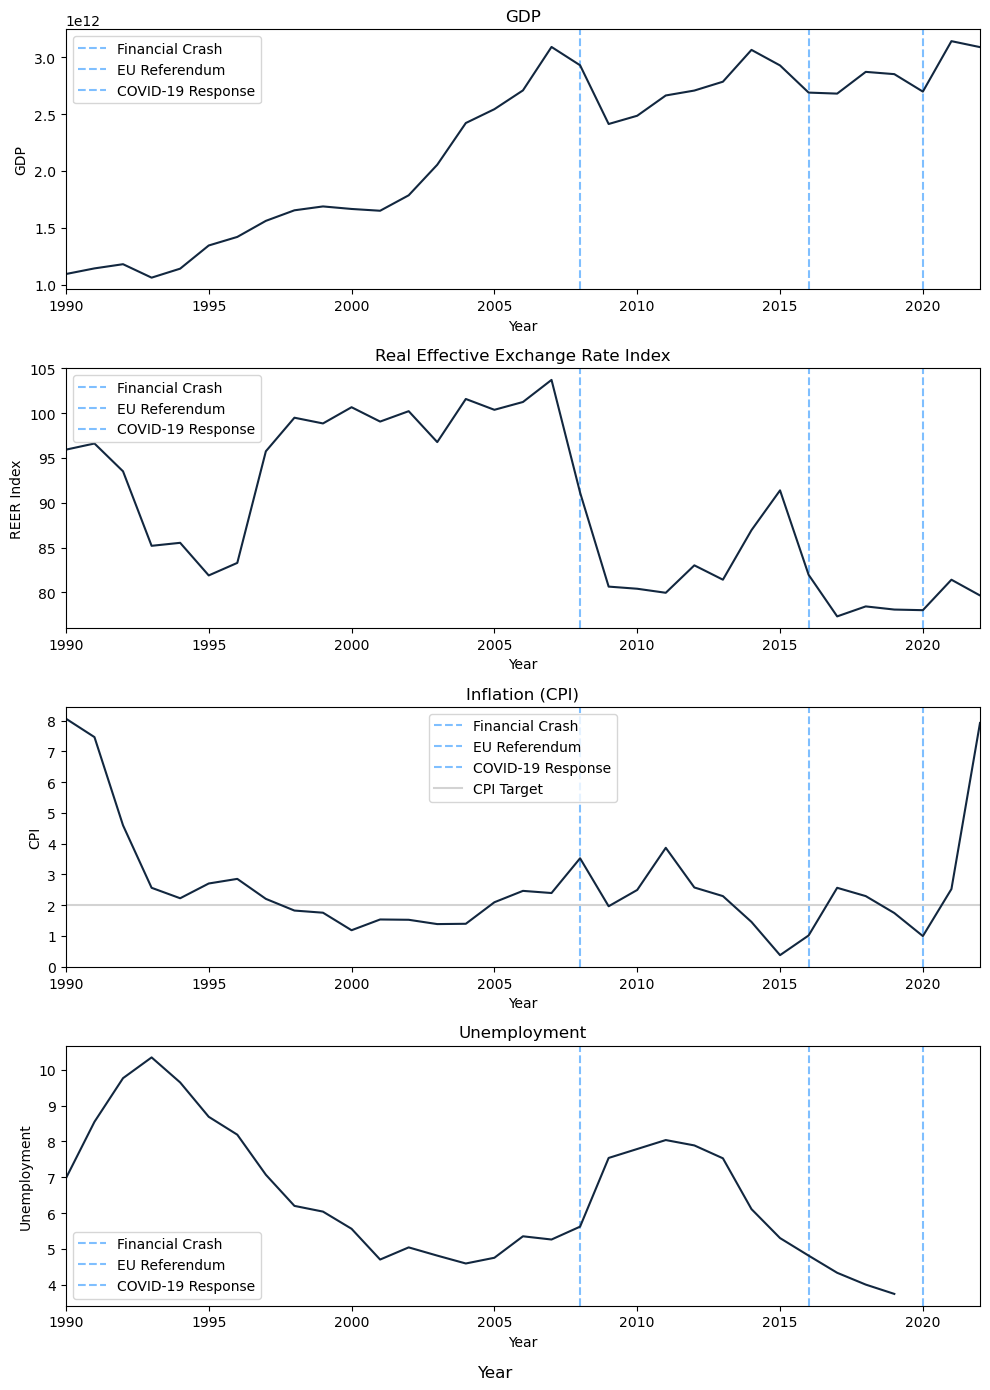

In [30]:
# Define custom colours
BoE_blue = '#12273f'
light_blue = '#7fbfff'

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 14))

# Plot each column on separate subplot
# GDP
axes[0].set_title('GDP')
axes[0].axvline(x=2008, color=light_blue, linestyle='--', label='Financial Crash')
axes[0].axvline(x=2016, color=light_blue, linestyle='--', label='EU Referendum')
axes[0].axvline(x=2020, color=light_blue, linestyle='--', label='COVID-19 Response')
axes[0].set_xlim(1990, 2022)
sns.lineplot(data=annual_indicators, x='Year', y='GDP', ax=axes[0], color=BoE_blue)

# REER Index
axes[1].set_title('Real Effective Exchange Rate Index')
axes[1].axvline(x=2008, color=light_blue, linestyle='--', label='Financial Crash')
axes[1].axvline(x=2016, color=light_blue, linestyle='--', label='EU Referendum')
axes[1].axvline(x=2020, color=light_blue, linestyle='--', label='COVID-19 Response')
axes[1].set_xlim(1990, 2022)
sns.lineplot(data=annual_indicators, x='Year', y='REER Index', ax=axes[1], color=BoE_blue)

# CPI
axes[2].set_title('Inflation (CPI)')
axes[2].axvline(x=2008, color=light_blue, linestyle='--', label='Financial Crash')
axes[2].axvline(x=2016, color=light_blue, linestyle='--', label='EU Referendum')
axes[2].axvline(x=2020, color=light_blue, linestyle='--', label='COVID-19 Response')
axes[2].set_xlim(1990, 2022)
axes[2].axhline(y=2, color='#D3D3D3', linestyle='-', label='CPI Target') # Inflation target
sns.lineplot(data=annual_indicators, x='Year', y='CPI', ax=axes[2], color=BoE_blue)

# Unemployment
axes[3].set_title('Unemployment')
axes[3].axvline(x=2008, color=light_blue, linestyle='--', label='Financial Crash')
axes[3].axvline(x=2016, color=light_blue, linestyle='--', label='EU Referendum')
axes[3].axvline(x=2020, color=light_blue, linestyle='--', label='COVID-19 Response')
axes[3].set_xlim(1990, 2022)
sns.lineplot(data=annual_indicators, x='Year', y='Unemployment', ax=axes[3], color=BoE_blue)

# Format the plot
# Add x-axis label
fig.supxlabel('Year')
# Adjust layout
plt.tight_layout()
# Add legend to the first subplot
axes[0].legend()
# Show the plot
plt.show()

## Bank Rate Data

Bank rate data is given as the bank rate changes. This is pre-cleaned, but will be formatted below and plotted as a step-plot.

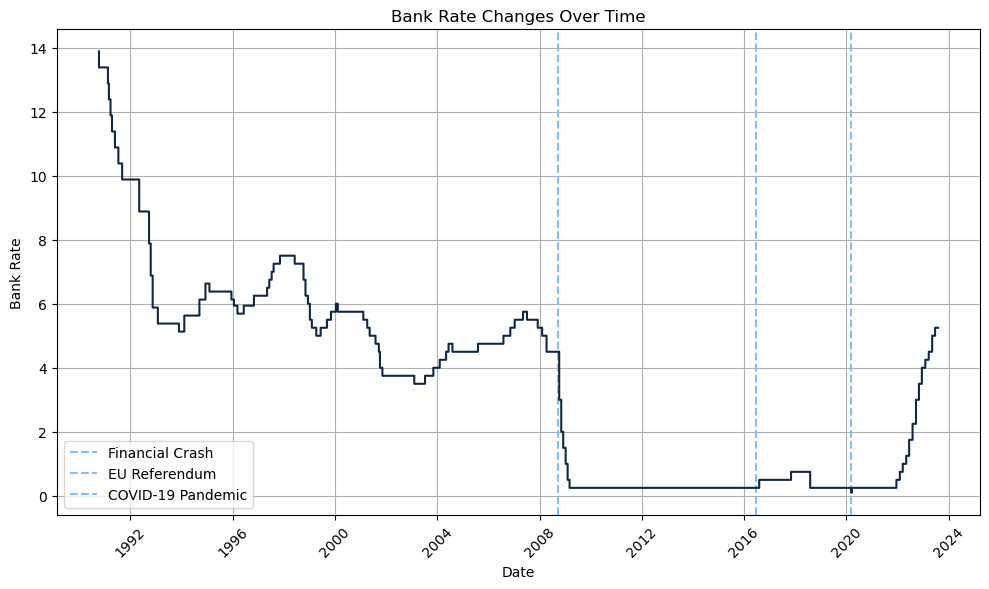

In [31]:
# Convert 'Date Changed' to datetime64 format
bank_rate['Date Changed'] = pd.to_datetime(bank_rate['Date Changed'], format='%d %b %y')

# Set the figure size
plt.figure(figsize=(10, 6))

# Add vertical lines for significant events
# Financial crash
plt.axvline(pd.to_datetime('2008-09-15'), color=light_blue, linestyle='--', label='Financial Crash')
# EU referendum
plt.axvline(pd.to_datetime('2016-06-23'), color=light_blue, linestyle='--', label='EU Referendum')
# COVID-19 pandemic
plt.axvline(pd.to_datetime('2020-03-11'), color=light_blue, linestyle='--', label='COVID-19 Pandemic')

# Create a step plot to show bank rate changes over time
plt.step(bank_rate['Date Changed'], bank_rate['Rate'], where='post', color=BoE_blue)

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Bank Rate')
plt.title('Bank Rate Changes Over Time')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend()
# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


### S&P500 and FTSE100

The column names have been formatted in excel, here we will remove null entries, format dates, and convert the FTSE 100 volume to the numerical value rather than 20 billion being represented as 20B (I have checked the data for values with M or T for million, trillion and there are none present, if not these would be converted also). I will also remove the percentages from change so that data may be handled correctly.

In [32]:
# Dropping rows with NaN values
SP500 = SP500.dropna(subset=['Date'])
FTSE100 = FTSE100.dropna(subset=['Date'])

# View dataframes
print('S&P 500:', SP500.head())
print('FTSE 100:', FTSE100.head())

S&P 500:           Date     Open     High      Low    Close  Adj_Close      Volume
0  01 Mar 2024  5101.50  5322.75  5063.00  5293.25    5293.25  24138166.0
1  01 Feb 2024  4874.50  5123.50  4872.50  5103.75    5103.75  30702486.0
2  01 Jan 2024  4818.00  4957.25  4702.00  4870.50    4870.50  34351121.0
3  01 Dec 2023  4571.75  4841.50  4548.75  4820.00    4820.00  28365508.0
4  01 Nov 2023  4205.00  4597.00  4191.25  4576.75    4576.75  32976841.0
FTSE 100:          Date     Price      Open      High       Low  Volume  Change
0  01/03/2024  7,930.96  7,630.02  7,961.99  7,598.46  20.41B   3.94%
1  01/02/2024  7,630.02  7,630.57  7,748.73  7,492.98  21.73B  -0.01%
2  01/01/2024  7,630.57  7,733.24  7,764.37  7,404.08  17.95B  -1.33%
3  01/12/2023  7,733.24  7,453.75  7,762.88  7,453.75  14.84B   3.75%
4  01/11/2023  7,453.75  7,321.72  7,533.77  7,304.89  15.17B   1.80%


In [33]:
# Replace 'Sept' with 'Sep'. The date formatter will not recognise 'Sept'.
SP500['Date'] = SP500['Date'].str.replace('Sept', 'Sep')

# format dates to datetime64 format
SP500['Date'] = pd.to_datetime(SP500['Date'], format='%d %b %Y')
FTSE100['Date'] = pd.to_datetime(FTSE100['Date'], format='%d/%m/%Y')

# Convert values like '20.41B' to numerical values representing billions
FTSE100['Volume'] = FTSE100['Volume'].str.replace('B', '').str.replace(',', '').astype(float) * 10**9

# Remove percentage signs from the 'Change' column in FTSE100
FTSE100['Change'] = FTSE100['Change'].str.rstrip('%').astype(float)

# Display the updated dataframes
print("S&P 500:")
print(SP500.head())
print("\nFTSE 100:")
print(FTSE100.head())

S&P 500:
        Date     Open     High      Low    Close  Adj_Close      Volume
0 2024-03-01  5101.50  5322.75  5063.00  5293.25    5293.25  24138166.0
1 2024-02-01  4874.50  5123.50  4872.50  5103.75    5103.75  30702486.0
2 2024-01-01  4818.00  4957.25  4702.00  4870.50    4870.50  34351121.0
3 2023-12-01  4571.75  4841.50  4548.75  4820.00    4820.00  28365508.0
4 2023-11-01  4205.00  4597.00  4191.25  4576.75    4576.75  32976841.0

FTSE 100:
        Date     Price      Open      High       Low        Volume  Change
0 2024-03-01  7,930.96  7,630.02  7,961.99  7,598.46  2.041000e+10    3.94
1 2024-02-01  7,630.02  7,630.57  7,748.73  7,492.98  2.173000e+10   -0.01
2 2024-01-01  7,630.57  7,733.24  7,764.37  7,404.08  1.795000e+10   -1.33
3 2023-12-01  7,733.24  7,453.75  7,762.88  7,453.75  1.484000e+10    3.75
4 2023-11-01  7,453.75  7,321.72  7,533.77  7,304.89  1.517000e+10    1.80


# Annual Indicators Differential

Below we take the differential of the annual indicators for insight exploration.

In [34]:
# Take the differential
annual_indicators[['GDP_diff',
                   'REER Index_diff', 
                   'CPI_diff', 
                   'Unemployment_diff']] = annual_indicators[['GDP','REER Index', 'CPI', 'Unemployment']].diff()
# Print first 5 rows.
annual_indicators.head()

,Year,GDP,REER Index,CPI,Unemployment,GDP_diff,REER Index_diff,CPI_diff,Unemployment_diff
0,1990,1.093169e+12,95.9259,8.06,6.97,NaN,NaN,NaN,NaN
1,1991,1.142797e+12,96.6151,7.46,8.55,4.962779e+10,0.6892,-0.60,1.58
2,1992,1.179660e+12,93.5074,4.59,9.77,3.686235e+10,-3.1077,-2.87,1.22
3,1993,1.061389e+12,85.1888,2.56,10.35,-1.182708e+11,-8.3186,-2.03,0.58
4,1994,1.140490e+12,85.5236,2.22,9.65,7.910102e+10,0.3348,-0.34,-0.70


### Plot Indicator Differentials

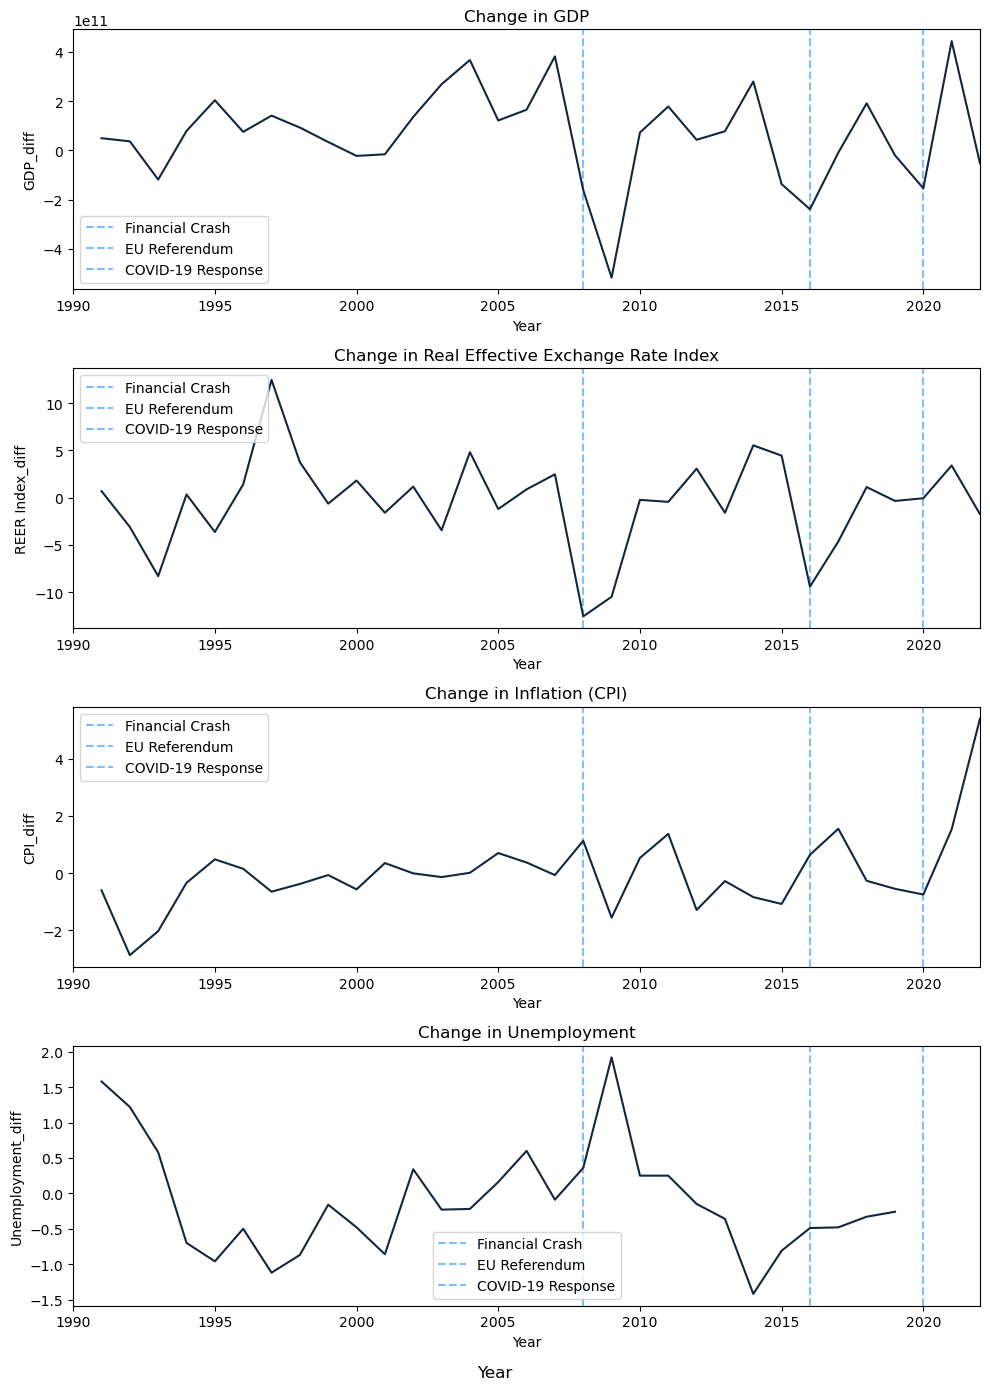

In [35]:
# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 14))

# Plot each column on separate subplot
# GDP
axes[0].set_title('Change in GDP')
axes[0].axvline(x=2008, color=light_blue, linestyle='--', label='Financial Crash')
axes[0].axvline(x=2016, color=light_blue, linestyle='--', label='EU Referendum')
axes[0].axvline(x=2020, color=light_blue, linestyle='--', label='COVID-19 Response')
axes[0].set_xlim(1990, 2022)
sns.lineplot(data=annual_indicators, x='Year', y='GDP_diff', ax=axes[0], color=BoE_blue)

# REER Index
axes[1].set_title('Change in Real Effective Exchange Rate Index')
axes[1].axvline(x=2008, color=light_blue, linestyle='--', label='Financial Crash')
axes[1].axvline(x=2016, color=light_blue, linestyle='--', label='EU Referendum')
axes[1].axvline(x=2020, color=light_blue, linestyle='--', label='COVID-19 Response')
axes[1].set_xlim(1990, 2022)
sns.lineplot(data=annual_indicators, x='Year', y='REER Index_diff', ax=axes[1], color=BoE_blue)

# Inflation
axes[2].set_title('Change in Inflation (CPI)')
axes[2].axvline(x=2008, color=light_blue, linestyle='--', label='Financial Crash')
axes[2].axvline(x=2016, color=light_blue, linestyle='--', label='EU Referendum')
axes[2].axvline(x=2020, color=light_blue, linestyle='--', label='COVID-19 Response')
axes[2].set_xlim(1990, 2022)
sns.lineplot(data=annual_indicators, x='Year', y='CPI_diff', ax=axes[2], color=BoE_blue)

# Unemployment
axes[3].set_title('Change in Unemployment')
axes[3].axvline(x=2008, color=light_blue, linestyle='--', label='Financial Crash')
axes[3].axvline(x=2016, color=light_blue, linestyle='--', label='EU Referendum')
axes[3].axvline(x=2020, color=light_blue, linestyle='--', label='COVID-19 Response')
axes[3].set_xlim(1990, 2022)
sns.lineplot(data=annual_indicators, x='Year', y='Unemployment_diff', ax=axes[3], color=BoE_blue)

# Add common x-axis label
fig.supxlabel('Year')

# Adjust layout
plt.tight_layout()

# Add legend to the first subplot
axes[0].legend()
plt.show()

# Store Cleaned Data

In [36]:
# Store the cleaned DataFrames.
annual_indicators.to_csv('annual_indicators.csv', index=False)
bank_rate.to_csv('bank_rate.csv', index=False)
SP500.to_csv('SP500.csv', index=False)
FTSE100.to_csv('FTSE100.csv', index=False)

# Assignment 3 (10/4/24 Onwards)

# Web Scraping

### This script is designed extract speeches from the Bank of England's website. It navigates from the sitemap to each individual speech page, handles  HTML and PDF formats and finally, compiles the collected data into CSV. Here is each section in a bit more detail:

> Set up scraping:

- Import necessary libraries: covering the he main processes like opening web pages (Selenium), processing HTML content (BeautifulSoup), handling PDFs (PyMuPDF), and organizing data (pandas).
- Initialize headless browser session for scraping: Sets up a way to visit web pages without opening an actual browser window (headless), using Selenium and a Chrome web driver. This is useful for automated data collection.
- Define the base URL and specifics: Sets the starting point of the scraping on the Bank of England's website (base, then sitemap) and prepares for the data collection process by initializing some variables.
- Initialize a web session for handling requests: This configures a session for making HTTP requests to download web content directly, pretending to be a regular web browser.

> Functions:

- 'extract_title_and_author(soup)':searches for the title and author in the header section
- 'extract_published_date(link)' specifically looks for and extracts the date when a speech was published on its web page.
- 'extract_text_from_pdf_url(pdf_url)' Some speeches are in PDF format on the individual URL. This code downloads the PDF and extracts its text content.
- 'clean_and_extract_text(html_content)' When speeches are in HTML format, this code navigates the structure of the web page to find and compile the speech text.

> Scraping process:

- Start scraping process from the Bank of England's speeches page: Opens the Bank of England's speeches page and starts the process of looking for speech links.
- Handle the cookie pop-up: This code tries to find and click the "Accept" button if a pop-up appears.
- Ensure the page has loaded and speeches are present: Waits to make sure that the webpage is fully loaded and that there are speeches available to scrape.

> Iterate through the specified number of speech URLs:

- Checks if the speech content is in HTML and tries to extract it
- collects the URL, publication date, author and title and text speech
- If not in HTML (or if it's missing), looks for a PDF link to download and extract text from.
- Collects the URL, publication date, author and title and text of each speech.
- Handles any errors that occur during these processes.

> Close and tidy up:

- Close browser session: After collecting all the necessary data, it properly closes the browser session.
- Save data to dataframe and write to CSV: Organizes the collected data into a structured table (dataframe) and saves it as a CSV file for easy access and use.
- Confirm the process is complete: Prints a message indicating that the scraping process has finished and where the data is saved.
- function 'format_time' coverts the time to easier to read format


> script 1. working script but adjusted to just scrape the first 10 as a test (which are pdf style)

> script 2. working script but adjusted to just scrape the last 10 as a test (which are both pdf and HTML style)

> script 3. the final script in full and runs for approximately 30 minutes

### 1. First 10 speeches test

In [37]:
start_time = time.time()  # Record the start time

# Initialize headless browser session for scraping
options = Options()
options.headless = True
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Define the base URL and specific path for the Bank of England's speeches page
base_url = "https://www.bankofengland.co.uk"
speeches_page = "/sitemap/speeches"
max_retries = 3
speeches_data = []

# Initialize a web session for handling requests and specify User-Agent to emulate a browser visit
session = requests.Session()
session.headers.update({'User-Agent': 'Mozilla/5.0'})

# function to extract title and author
def extract_title_and_author(soup):
    # Find the <h1> tag with the itemprop attribute set to 'name'
    h1_tag = soup.find('h1', itemprop='name')
    if not h1_tag:
        return "Title not found", "Author not found"

    # Get the h1 text and try to find the author using known phrases
    h1_text = h1_tag.get_text(strip=True)
    author_patterns = [
        "speech by", "remarks by", "delivered by", "given by", 
        "address by", "comments by", "lecture by", "presentation by",
        "paper by", "- by", "authored by"
    ]

    # Try to match each pattern and split the text accordingly
    for pattern in author_patterns:
        if pattern in h1_text.lower():
            # Split the text by the pattern
            title_author_split = re.split(pattern, h1_text, flags=re.IGNORECASE)
            if len(title_author_split) > 1:
                # Title is before the pattern, author is after
                title = title_author_split[0].strip(' -')
                author = title_author_split[1].strip(' -')
                return title, author
            else:
                # If the split didn't work, the entire text is likely the author's name.
                return "Title not found", h1_text.strip(' -')

    # If none of the patterns match, return the whole <h1> as the title and 'Unknown' as the author
    return h1_text, 'Unknown'


# Define a function to extract the publication date from the speech page        
def extract_published_date(link):
    # Send a request to the page where the PDF link is located
    response = session.get(link)
    # If the request is successful, parse the page and find the publication date
    if response.ok:
        soup = BeautifulSoup(response.text, 'html.parser')
        date_div = soup.find('div', class_='published-date')
        return date_div.get_text(strip=True) if date_div else "Date not found"
    return None

# Define a function to extract text from a PDF given its URL
def extract_text_from_pdf_url(pdf_url):
    # Ensure URL is complete
    if not pdf_url.startswith('http'):
        pdf_url = f"{base_url}{pdf_url}"
    # Send a request to get the PDF content
    try:
        response = session.get(pdf_url)
        response.raise_for_status()  # Ensure we actually got the file
        # Extract text from PDF
        with fitz.open(stream=BytesIO(response.content), filetype="pdf") as doc:
            return "".join(page.get_text() for page in doc)
    except fitz.PDFError as e:
        print(f"A PDF error occurred with the PDF at {pdf_url}: {e}")
        return None
    except requests.exceptions.RequestException as e:
        print(f"An HTTP request error occurred with the PDF at {pdf_url}: {e}")
        return None
    except Exception as e:
        print(f"An unspecified error occurred with the PDF at {pdf_url}: {e}")
        return None
    

# Function to clean up, assemble then extract text from the main content section of HTML style URL pages 
def clean_and_extract_text(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    content_text = "Content not found"
    
    # Find the <h2> tag with the text 'Speech'
    speech_start_tag = soup.find('h2', string='Speech') 
    if speech_start_tag:
        # Collect the 'siblings' of the <h2> tag which contain the actual speech content
        content_pieces = []
        for sibling in speech_start_tag.find_next_siblings():
            # Check if we have not reached another <h2> tag which might indicate the end of the speech content
            if sibling.name == "h2":
                break
            # Add the text of the current element to our list if it's not an 'img-block' class
            if 'img-block' not in sibling.get('class', []):
                content_pieces.append(sibling.get_text(separator=' ', strip=True))

        # Join the pieces of text we've collected
        content_text = ' '.join(content_pieces)
    return content_text


# Start scraping process from the Bank of England's speeches page
driver.get(f"{base_url}{speeches_page}")

# Handle the cookie pop-up by accepting cookies if present
try:
    accept_cookies_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Accept recommended cookies')]"))
    )
    accept_cookies_button.click()
except TimeoutException:
    print("No cookie pop-up appeared within 10 seconds.")

# Ensure the page has loaded and speeches are present
try:
    print("Waiting for speech links to be present...")
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.list-links__link"))
    )

    # Use BeautifulSoup to parse the HTML content
    page_html = driver.page_source
    soup = BeautifulSoup(page_html, 'html.parser')

    # Find the 'Documents' section in html code
    documents_marker = soup.find('h2', string='Documents')

    # Find all the speech links that appear before the 'Documents' marker
    speech_urls = []
    if documents_marker:
        for link in documents_marker.find_all_previous('a', class_='list-links__link'):
            speech_url = link.get('href').strip()  # Ensure URL is complete and remove any surrounding whitespace
            if speech_url and not speech_url.startswith('http'):
                speech_url = f"{base_url}{speech_url}"
            speech_urls.append(speech_url)
        speech_urls.reverse()  # Reverse the list to maintain the original, order (ordered by year only)

    # Iterate through the specified number of speech URLs each URL is 'url'
    for url in speech_urls[:10]:  # Adjust [:10] / [-:10] as needed to test head / tail of database
        print(f"Processing {url}")
        time.sleep(0.5)  # Throttle requests to avoid server issues

        # Initialize speech data structure for each URL
        speech_data = {
            'url': url,
            'date_published': 'Date not found',
            'text': 'Content not found',
            'title': 'Title not found',  
            'author': 'Author not found'  # New field for author
        }

        try:
            speech_response = session.get(url)
            if speech_response.ok:
                speech_soup = BeautifulSoup(speech_response.text, 'html.parser')

                # extract text from HTML content first due to occassional PDFs like 'notes' / 'references'
                extracted_text = clean_and_extract_text(speech_response.text)

                if extracted_text != "Content not found":
                    speech_data['text'] = extracted_text
                    speech_data['date_published'] = extract_published_date(url)  # Update the publication date if content was found
                    # After fetching the URL and creating the soup object
                    title, author = extract_title_and_author(speech_soup)
                    speech_data['title'] = title
                    speech_data['author'] = author # include the new functions to within this HTML loop
                else:
                    # If no HTML content was found, look for a PDF link
                    pdf_link = speech_soup.select_one("a.btn-pubs[href$='.pdf']")
                    if pdf_link:
                        pdf_url = pdf_link['href'].strip()
                        if not pdf_url.startswith('http'):
                            pdf_url = f"{base_url}{pdf_url}"
                        speech_data['text'] = extract_text_from_pdf_url(pdf_url)
                        # repeat the steps to call the functions
                        speech_data['date_published'] = extract_published_date(url)
                        title, author = extract_title_and_author(speech_soup)
                        speech_data['title'] = title
                        speech_data['author'] = author
                # Append the data to the list if content was extracted
                if speech_data['text'] != 'Content not found':
                    speeches_data.append(speech_data)
            else:
                print(f"Failed to fetch {url}, status code {speech_response.status_code}")
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {url}: {e}")
except TimeoutException as e:
    print(f"Page did not load properly or no speeches found: {e}")
            
# Close browser session
driver.quit()
    
# Save data to dataframe and write to CSV
df_speeches_first_10 = pd.DataFrame(speeches_data)
# Get the current directory where the script is located
current_directory = os.path.dirname(os.path.abspath('Data_Cleaning_and_Preparation.ipynb'))
# Define the CSV file name
csv_file_name = 'boe_speeches_first_10.csv'
# Construct the file path by joining the current directory and the file name
csv_file_path = os.path.join(current_directory, csv_file_name)

df_speeches_first_10.to_csv(csv_file_path, index=False)

# Confirm the process is complete
print(f"Scraping complete. Data saved to {csv_file_path}")

# Record date and time scraped
scrape_date = datetime.now()
print(f"date of scrape: {scrape_date}") 

end_time = time.time()  # Record the end time

# Calculate the difference in seconds
elapsed_time_1 = end_time - start_time
print(f"Total scraping time: {elapsed_time_1:.2f} seconds")

No cookie pop-up appeared within 10 seconds.
Waiting for speech links to be present...
Processing https://www.bankofengland.co.uk/speech/1997/developments-in-uk-financial-markets
Processing https://www.bankofengland.co.uk/speech/1997/edward-george-lord-mayors-banquet
Processing https://www.bankofengland.co.uk/speech/1997/edward-george-queen-elizabeth-conference-centre
Processing https://www.bankofengland.co.uk/speech/1997/edward-george-the-sixteenth-mais-lecture
Processing https://www.bankofengland.co.uk/speech/1997/the-inflation-target-five-years-on
Processing https://www.bankofengland.co.uk/speech/1998/alice-in-euroland
Processing https://www.bankofengland.co.uk/speech/1998/britain-in-europe
Processing https://www.bankofengland.co.uk/speech/1998/britain-in-europe-at-the-borsen
Processing https://www.bankofengland.co.uk/speech/1998/economic-policy-with-and-without-forecasts
Processing https://www.bankofengland.co.uk/speech/1998/edward-george-institute-of-directors
Scraping complete. D

In [38]:
# check time in full format
def format_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours)}h:{int(minutes)}m:{seconds:.2f}s"

# Then print it formatted
print(f"Total scraping time: {format_time(elapsed_time_1)}")


Total scraping time: 0h:0m:53.09s


In [39]:
df_speeches_first_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             10 non-null     object
 1   date_published  10 non-null     object
 2   text            10 non-null     object
 3   title           10 non-null     object
 4   author          10 non-null     object
dtypes: object(5)
memory usage: 528.0+ bytes


In [40]:
df_speeches_first_10

,url,date_published,text,title,author
0,https://www.bankofengland.co.uk/speech/1997/de...,Published on \r\n 18 November 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Developments in UK financial markets,Ian Plenderleith
1,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 12 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Lord Mayor's Banquet,Edward George
2,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 25 February 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,,Edward George for the 3rd Euromoney Internatio...
3,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 24 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Sixteenth Mais Lecture,Edward George
4,https://www.bankofengland.co.uk/speech/1997/th...,Published on \r\n 29 October 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Inflation Target five years on - lecture,Mervyn King
5,https://www.bankofengland.co.uk/speech/1998/al...,Published on \r\n 15 December 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Alice in Euroland,Willem H. Buiter
6,https://www.bankofengland.co.uk/speech/1998/br...,Published on \r\n 21 October 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Britain in Europe,Edward George
7,https://www.bankofengland.co.uk/speech/1998/br...,Published on \r\n 06 March 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Britain in Europe,Edward George
8,https://www.bankofengland.co.uk/speech/1998/ec...,Published on \r\n 01 November 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \nAll ...,"Economic policy, with and without forecasts",Sir Alan Budd
9,https://www.bankofengland.co.uk/speech/1998/ed...,Published on \r\n 19 November 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,,Edward George at the Institute of Directors An...


In [41]:
for index, row in df_speeches_first_10.iterrows():
    print(f"Text for row {index}:")
    print(row['text'])
    print("-----")  # Separator for readability

Text for row 0:
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 
1 
 
 
 
 
Developments in UK financial markets 
 
Speech given by 
Ian Plenderleith 
 
18 November 1997 
 
 
 
 
 
 
 
All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 
2 
 
2
 
 
This has been a year marked by important developments in the UK financial markets and I am delighted to 
have this opportunity to take you through some of the highlights.  
 
The UK’s new monetary framework  
 
Perhaps the single most momentous change in the financial landscape in the UK has been the new 
Government’s decision, in May, to give operational responsibility for interest rates to the Bank of England - 
essentially, to establish operational independence for the central bank. This significant reform, which took 
effect immediately, and is to be the subject of legislation recently introduced in the 

### 2. last 10 speeches test

In [42]:
start_time = time.time()  # Record the start time

# Initialize headless browser session for scraping
options = Options()
options.headless = True
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Define the base URL and specific path for the Bank of England's speeches page
base_url = "https://www.bankofengland.co.uk"
speeches_page = "/sitemap/speeches"
max_retries = 3
speeches_data = []

# Initialize a web session for handling requests and specify User-Agent to emulate a browser visit
session = requests.Session()
session.headers.update({'User-Agent': 'Mozilla/5.0'})

# Start scraping process from the Bank of England's speeches page
driver.get(f"{base_url}{speeches_page}")

# Handle the cookie pop-up by accepting cookies if present
try:
    accept_cookies_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Accept recommended cookies')]"))
    )
    accept_cookies_button.click()
except TimeoutException:
    print("No cookie pop-up appeared within 10 seconds.")

# Ensure the page has loaded and speeches are present
try:
    print("Waiting for speech links to be present...")
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.list-links__link"))
    )

    # Use BeautifulSoup to parse the HTML content
    page_html = driver.page_source
    soup = BeautifulSoup(page_html, 'html.parser')

    # Find the 'Documents' section in html code
    documents_marker = soup.find('h2', string='Documents')

    # Find all the speech links that appear before the 'Documents' marker
    speech_urls = []
    if documents_marker:
        for link in documents_marker.find_all_previous('a', class_='list-links__link'):
            speech_url = link.get('href').strip()  # Ensure URL is complete and remove any surrounding whitespace
            if speech_url and not speech_url.startswith('http'):
                speech_url = f"{base_url}{speech_url}"
            speech_urls.append(speech_url)
        speech_urls.reverse()  # Reverse the list to maintain the original, order (ordered by year only)

    # Iterate through the specified number of speech URLs each URL is 'url'
    for url in speech_urls[-10:]:  # Adjust [:10] / [-:10] as needed to test head / tail of database
        print(f"Processing {url}")
        time.sleep(0.5)  # Throttle requests to avoid server issues

        # Initialize speech data structure for each URL
        speech_data = {
            'url': url,
            'date_published': 'Date not found',
            'text': 'Content not found',
            'title': 'Title not found',  
            'author': 'Author not found'  # New field for author
        }

        try:
            speech_response = session.get(url)
            if speech_response.ok:
                speech_soup = BeautifulSoup(speech_response.text, 'html.parser')

                # extract text from HTML content first due to occassional PDFs like 'notes' / 'references'
                extracted_text = clean_and_extract_text(speech_response.text)

                if extracted_text != "Content not found":
                    speech_data['text'] = extracted_text
                    speech_data['date_published'] = extract_published_date(url)  # Update the publication date if content was found
                    # After fetching the URL and creating the soup object
                    title, author = extract_title_and_author(speech_soup)
                    speech_data['title'] = title
                    speech_data['author'] = author # include the new functions to within this HTML loop
                else:
                    # If no HTML content was found, look for a PDF link
                    pdf_link = speech_soup.select_one("a.btn-pubs[href$='.pdf']")
                    if pdf_link:
                        pdf_url = pdf_link['href'].strip()
                        if not pdf_url.startswith('http'):
                            pdf_url = f"{base_url}{pdf_url}"
                        speech_data['text'] = extract_text_from_pdf_url(pdf_url)
                        # repeat the steps to call the functions
                        speech_data['date_published'] = extract_published_date(url)
                        title, author = extract_title_and_author(speech_soup)
                        speech_data['title'] = title
                        speech_data['author'] = author
                # Append the data to the list if content was extracted
                if speech_data['text'] != 'Content not found':
                    speeches_data.append(speech_data)
            else:
                print(f"Failed to fetch {url}, status code {speech_response.status_code}")
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {url}: {e}")
except TimeoutException as e:
    print(f"Page did not load properly or no speeches found: {e}")
            
# Close browser session
driver.quit()
    
# Save data to dataframe and write to CSV
df_speeches_last_10 = pd.DataFrame(speeches_data)
# Get the current directory where the script is located
current_directory = os.path.dirname(os.path.abspath('Data_Cleaning_and_Preparation.ipynb'))
# Define the CSV file name
csv_file_name = 'boe_speeches_last_10.csv'
# Construct the file path by joining the current directory and the file name
csv_file_path = os.path.join(current_directory, csv_file_name)
# Store the file
df_speeches_last_10.to_csv(csv_file_path, index=False)

# Confirm the process is complete
print(f"Scraping complete. Data saved to {csv_file_path}")

# Record date and time scraped
scrape_date = datetime.now()
print(f"date of scrape: {scrape_date}") 
      
end_time = time.time()  # Record the end time

# Calculate the difference in seconds
elapsed_time_2 = end_time - start_time
print(f"Total scraping time: {elapsed_time_2:.2f} seconds")

Waiting for speech links to be present...
Processing https://www.bankofengland.co.uk/speech/2024/february/megan-greene-fireside-chat-with-brian-coulton-chief-economist-fitch-ratings
Processing https://www.bankofengland.co.uk/speech/2024/february/sarah-breeden-keynote-speech-uk-women-in-economics-annual-networking
Processing https://www.bankofengland.co.uk/speech/2024/february/swati-dhingra-market-news-international-connect-event
Processing https://www.bankofengland.co.uk/speech/2024/january/lee-foulger-keynote-address-at-the-dealcatalyst-afme-european-direct-lending
Processing https://www.bankofengland.co.uk/speech/2024/january/victoria-cleland-speech-on-supporting-payments-innovation-through-rtgs
Processing https://www.bankofengland.co.uk/speech/2024/march/gareth-truran-keynote-speech-at-the-techuk-summit
Processing https://www.bankofengland.co.uk/speech/2024/march/huw-pill-speech-at-the-cardiff-university-business-school
Processing https://www.bankofengland.co.uk/speech/2024/march/ja

In [43]:
# Print formatted time
print(f"Total scraping time: {format_time(elapsed_time_2)}")

Total scraping time: 0h:0m:41.43s


In [44]:
df_speeches_last_10

,url,date_published,text,title,author
0,https://www.bankofengland.co.uk/speech/2024/fe...,Published on \r\n 15 February 2024,"Introduction I’m delighted to be at Fitch, whe...",Worlds apart? UK inflation and monetary policy...,Megan Greene
1,https://www.bankofengland.co.uk/speech/2024/fe...,Published on \r\n 21 February 2024,Bank of England \n \n Page 1 \n \n \n \n \n \...,Money’s too tight (to mention) –,Swati Dhingra
2,https://www.bankofengland.co.uk/speech/2024/ja...,Published on \r\n 29 January 2024,Good morning. My name is Lee Foulger and I am ...,"Non-bank risks, financial stability and the ro...",Lee Foulger
3,https://www.bankofengland.co.uk/speech/2024/ja...,Published on \r\n 25 January 2024,Technological innovation coupled with shifts i...,The Real Time Gross Settlement service: an ope...,Victoria Cleland
4,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 08 March 2024,Good morning. I’m very pleased to be here toda...,The proposed UK regime for critical third part...,Gareth Truran
5,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 01 March 2024,Bank of England \n \n Page 1 \n \n \n \nMonet...,Monetary Policy Strategy −,Huw Pill
6,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 07 March 2024,Good morning. It is a pleasure to be here to s...,A weathervane for a changing world: refreshing...,James Benford
7,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 12 March 2024,"Last Autumn, Andrew Hauser, the then Executive...","Market resilience, non-bank financial institut...",Nick Butt


In [45]:
for index, row in df_speeches_last_10.tail(5).iterrows():
    print(f"Text for row {index}:")
    print(row['text'])
    print("-----")  # Separator for readability

Text for row 3:
Technological innovation coupled with shifts in demand for payment services is driving transformation in the financial and payment landscape. Today I will outline how the Bank of England is enhancing its core payments infrastructure to support this change. The way users transact has changed significantly in recent years, and continues to evolve. There has been a decisive move towards electronic payments and an increasing trend toward always-on, real-time retail and wholesale transactions. Contactless payments using not just cards but also phones and watches are now widely used, and online payments continue to increase. This change is not just about technology but a fundamental shift in user behaviour and preferences. More people now expect financial transactions to keep pace with the speed of digital communication. The nature of transactions is also changing, with a continued growth in cross-border payment values. Global payments are expected to increase significantly b

### 3. full scrape (27 mins)

In [ ]:
start_time = time.time()  # Record the start time

# Initialize headless browser session for scraping
options = Options()
options.headless = True
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Define the base URL and specific path for the Bank of England's speeches page
base_url = "https://www.bankofengland.co.uk"
speeches_page = "/sitemap/speeches"
max_retries = 3
speeches_data = []

# Initialize a web session for handling requests and specify User-Agent to emulate a browser visit
session = requests.Session()
session.headers.update({'User-Agent': 'Mozilla/5.0'})

# Start scraping process from the Bank of England's speeches page
driver.get(f"{base_url}{speeches_page}")

# Handle the cookie pop-up by accepting cookies if present
try:
    accept_cookies_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Accept recommended cookies')]"))
    )
    accept_cookies_button.click()
except TimeoutException:
    print("No cookie pop-up appeared within 10 seconds.")

# Ensure the page has loaded and speeches are present
try:
    print("Waiting for speech links to be present...")
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.list-links__link"))
    )

    # Use BeautifulSoup to parse the HTML content
    page_html = driver.page_source
    soup = BeautifulSoup(page_html, 'html.parser')

    # Find the 'Documents' section in html code
    documents_marker = soup.find('h2', string='Documents')

    # Find all the speech links that appear before the 'Documents' marker
    speech_urls = []
    if documents_marker:
        for link in documents_marker.find_all_previous('a', class_='list-links__link'):
            speech_url = link.get('href').strip()  # Ensure URL is complete and remove any surrounding whitespace
            if speech_url and not speech_url.startswith('http'):
                speech_url = f"{base_url}{speech_url}"
            speech_urls.append(speech_url)
        speech_urls.reverse()  # Reverse the list to maintain the original, order (ordered by year only)

    # Iterate through the specified number of speech URLs each URL is 'url'
    for url in speech_urls: 
        print(f"Processing {url}")
        time.sleep(0.5)  # Throttle requests to avoid server issues

        # Initialize speech data structure for each URL
        speech_data = {
            'url': url,
            'date_published': 'Date not found',
            'text': 'Content not found',
            'title': 'Title not found',  
            'author': 'Author not found'  # New field for author
        }

        try:
            speech_response = session.get(url)
            if speech_response.ok:
                speech_soup = BeautifulSoup(speech_response.text, 'html.parser')

                # extract text from HTML content first due to occassional PDFs like 'notes' / 'references'
                extracted_text = clean_and_extract_text(speech_response.text)

                if extracted_text != "Content not found":
                    speech_data['text'] = extracted_text
                    speech_data['date_published'] = extract_published_date(url)  # Update the publication date if content was found
                    # After fetching the URL and creating the soup object
                    title, author = extract_title_and_author(speech_soup)
                    speech_data['title'] = title
                    speech_data['author'] = author # include the new functions to within this HTML loop
                else:
                    # If no HTML content was found, look for a PDF link
                    pdf_link = speech_soup.select_one("a.btn-pubs[href$='.pdf']")
                    if pdf_link:
                        pdf_url = pdf_link['href'].strip()
                        if not pdf_url.startswith('http'):
                            pdf_url = f"{base_url}{pdf_url}"
                        speech_data['text'] = extract_text_from_pdf_url(pdf_url)
                        # repeat the steps to call the functions
                        speech_data['date_published'] = extract_published_date(url)
                        title, author = extract_title_and_author(speech_soup)
                        speech_data['title'] = title
                        speech_data['author'] = author
                # Append the data to the list if content was extracted
                if speech_data['text'] != 'Content not found':
                    speeches_data.append(speech_data)
            else:
                print(f"Failed to fetch {url}, status code {speech_response.status_code}")
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {url}: {e}")
except TimeoutException as e:
    print(f"Page did not load properly or no speeches found: {e}")
            
# Close browser session
driver.quit()

# Save data to dataframe and write to CSV
df_speeches_final = pd.DataFrame(speeches_data)
# Get the current directory where the script is located
current_directory = os.path.dirname(os.path.abspath('Data_Cleaning_and_Preparation.ipynb'))
# Define the CSV file name
csv_file_name = 'boe_speeches_final.csv'
# Construct the file path by joining the current directory and the file name
csv_file_path = os.path.join(current_directory, csv_file_name)
# Store the file
df_speeches_final.to_csv(csv_file_path, index=False)

# Confirm the process is complete
print(f"Scraping complete. Data saved to {csv_file_path}")

# Record date and time scraped
scrape_date = datetime.now()
print(f"date of scrape: {scrape_date}") 

end_time = time.time()  # Record the end time

# Calculate the difference in seconds
elapsed_time_3 = end_time - start_time
print(f"Total scraping time: {elapsed_time_3:.2f} seconds")

Waiting for speech links to be present...
Processing https://www.bankofengland.co.uk/speech/1997/developments-in-uk-financial-markets
Processing https://www.bankofengland.co.uk/speech/1997/edward-george-lord-mayors-banquet
Processing https://www.bankofengland.co.uk/speech/1997/edward-george-queen-elizabeth-conference-centre
Processing https://www.bankofengland.co.uk/speech/1997/edward-george-the-sixteenth-mais-lecture
Processing https://www.bankofengland.co.uk/speech/1997/the-inflation-target-five-years-on
Processing https://www.bankofengland.co.uk/speech/1998/alice-in-euroland
Processing https://www.bankofengland.co.uk/speech/1998/britain-in-europe
Processing https://www.bankofengland.co.uk/speech/1998/britain-in-europe-at-the-borsen
Processing https://www.bankofengland.co.uk/speech/1998/economic-policy-with-and-without-forecasts
Processing https://www.bankofengland.co.uk/speech/1998/edward-george-institute-of-directors
Processing https://www.bankofengland.co.uk/speech/1998/edward-geo

Processing https://www.bankofengland.co.uk/speech/2001/banking-supervision-and-financial-stability-from-an-international-perspective
Processing https://www.bankofengland.co.uk/speech/2001/banks-and-the-systemic-risk-theory-and-evidence
Processing https://www.bankofengland.co.uk/speech/2001/centre-for-financial-studies-seminar
Processing https://www.bankofengland.co.uk/speech/2001/chartered-institute-of-bankers-in-scotland-biennnial-dinner
Processing https://www.bankofengland.co.uk/speech/2001/current-threats-to-global-financial-stability-a-european-view
Processing https://www.bankofengland.co.uk/speech/2001/deanne-julius-speech
Processing https://www.bankofengland.co.uk/speech/2001/debt-workouts-for-corporates-banks-and-countries-some-common-themes
Processing https://www.bankofengland.co.uk/speech/2001/do-we-have-a-new-economy
Processing https://www.bankofengland.co.uk/speech/2001/economic-imbalances-and-uk-monetary-policy
Processing https://www.bankofengland.co.uk/speech/2001/edward-g

Processing https://www.bankofengland.co.uk/speech/2003/financial-stability-maintaining-confidence-in-a-complex-world
Processing https://www.bankofengland.co.uk/speech/2003/inflation-targeting-the-uk-experience
Processing https://www.bankofengland.co.uk/speech/2003/poverty-and-worklessness-in-britain
Processing https://www.bankofengland.co.uk/speech/2003/the-role-of-the-boe-in-the-gold-market
Processing https://www.bankofengland.co.uk/speech/2003/two-current-monetary-policy-issues
Processing https://www.bankofengland.co.uk/speech/2003/uk-monetary-policy-in-a-changing-world
Processing https://www.bankofengland.co.uk/speech/2004/a-picture-of-european-unemployment-success-and-failure
Processing https://www.bankofengland.co.uk/speech/2004/annual-birmingham-forward-cbi-business-luncheon
Processing https://www.bankofengland.co.uk/speech/2004/asset-prices-monetary-policy-and-financial-stability
Processing https://www.bankofengland.co.uk/speech/2004/boring-bankers-should-we-listen
Processing ht

Processing https://www.bankofengland.co.uk/speech/2006/reflections-on-my-first-four-votes-on-the-mpc
Processing https://www.bankofengland.co.uk/speech/2006/reflections-on-operating-inflation-targeting
Processing https://www.bankofengland.co.uk/speech/2006/reform-of-the-international-monetary-fund
Processing https://www.bankofengland.co.uk/speech/2006/risks-to-the-commercial-property-market-and-financial-stability
Processing https://www.bankofengland.co.uk/speech/2006/stability-and-change
Processing https://www.bankofengland.co.uk/speech/2006/the-budget-of-1981-was-over-the-top
Processing https://www.bankofengland.co.uk/speech/2006/the-puzzle-of-uk-business-investment
Processing https://www.bankofengland.co.uk/speech/2006/the-uk-current-account-deficit-and-all-that
Processing https://www.bankofengland.co.uk/speech/2006/through-the-looking-glass-reform-of-the-international-institutions
Processing https://www.bankofengland.co.uk/speech/2006/trusting-in-money-from-kirkcaldy-to-the-mpc
Proc

MuPDF error: format error: No default Layer config


Processing https://www.bankofengland.co.uk/speech/2008/some-current-issues-in-uk-monetary-policy
Processing https://www.bankofengland.co.uk/speech/2008/some-lessons-for-monetary-policy-from-the-recent-financial-turmoil
Processing https://www.bankofengland.co.uk/speech/2008/sovereign-wealth-funds-and-global-imbalances
Processing https://www.bankofengland.co.uk/speech/2008/strengthening-regimes-for-controlling-liquidity-risk-some-lessons-from-the-recent-turmoil
Processing https://www.bankofengland.co.uk/speech/2008/the-credit-crunch-and-the-uk-economy
Processing https://www.bankofengland.co.uk/speech/2008/the-current-downturn-a-bust-without-a-boom
Processing https://www.bankofengland.co.uk/speech/2008/the-financial-cycle-and-the-uk-economy
Processing https://www.bankofengland.co.uk/speech/2008/the-impact-of-the-financial-market-disruption-on-the-uk-economy
Processing https://www.bankofengland.co.uk/speech/2008/the-new-financial-frontiers
Processing https://www.bankofengland.co.uk/speech/

MuPDF error: format error: No default Layer config


Processing https://www.bankofengland.co.uk/speech/2009/money-banks-and-quantitative-easing
Processing https://www.bankofengland.co.uk/speech/2009/prospects-for-the-british-economy-after-the-financial-storm
Processing https://www.bankofengland.co.uk/speech/2009/quantitative-easing-and-interim-report
Processing https://www.bankofengland.co.uk/speech/2009/recovery-and-resolution-plans
Processing https://www.bankofengland.co.uk/speech/2009/regimes-for-handling-bank-failures-redrawing-the-banking-social-contract
Processing https://www.bankofengland.co.uk/speech/2009/remarks-at-the-birmingham-museums-and-art-gallery
Processing https://www.bankofengland.co.uk/speech/2009/rethinking-the-financial-network
Processing https://www.bankofengland.co.uk/speech/2009/seperating-fact-from-fiction-household-balance-sheets-and-the-economic-outlook
Processing https://www.bankofengland.co.uk/speech/2009/seven-lessons-from-the-last-three-years
Processing https://www.bankofengland.co.uk/speech/2009/small-less

MuPDF error: format error: No default Layer config


Processing https://www.bankofengland.co.uk/speech/2009/stability-instability-and-monetary-policy
Processing https://www.bankofengland.co.uk/speech/2009/the-bank-of-englands-balance-sheet
Processing https://www.bankofengland.co.uk/speech/2009/the-crisis-management-menu
Processing https://www.bankofengland.co.uk/speech/2009/the-debate-on-financial-system-resiliance
Processing https://www.bankofengland.co.uk/speech/2009/the-economic-outlook
Processing https://www.bankofengland.co.uk/speech/2009/the-formation-of-inflation-expectations-an-emperical-analysis-for-the-uk
Processing https://www.bankofengland.co.uk/speech/2009/the-future-financial-landscape
Processing https://www.bankofengland.co.uk/speech/2009/the-future-of-monetary-policy
Processing https://www.bankofengland.co.uk/speech/2009/the-great-moderation-the-panic-and-the-great-contraction
Processing https://www.bankofengland.co.uk/speech/2009/the-road-to-recovery-and-the-inflation-target
Processing https://www.bankofengland.co.uk/spe

MuPDF error: format error: No default Layer config


Processing https://www.bankofengland.co.uk/speech/2009/the-uk-bank-resolution-regime
Processing https://www.bankofengland.co.uk/speech/2009/tough-times-unconventional-measures
Processing https://www.bankofengland.co.uk/speech/2009/turner-review-conference
Processing https://www.bankofengland.co.uk/speech/2009/what-should-be-done-about-rising-unemployment-in-the-uk
Processing https://www.bankofengland.co.uk/speech/2009/why-banks-failed-the-stress-test
Processing https://www.bankofengland.co.uk/speech/2010/2010-a-progress-report-speech-by-spencer-dale
Processing https://www.bankofengland.co.uk/speech/2010/after-the-recession-thoughts-on-the-growth-potential-of-the-uk-speech-by-martin-weale
Processing https://www.bankofengland.co.uk/speech/2010/banking-from-bagehot-to-basel-and-back-again-speech-by-mervyn-king
Processing https://www.bankofengland.co.uk/speech/2010/banknotes-meeting-demand-speech-by-victoria-cleland
Processing https://www.bankofengland.co.uk/speech/2010/curbing-the-credit-

Processing https://www.bankofengland.co.uk/speech/2011/let-it-grow-how-monetary-policy-can-support-sustainable-economic-growth-speech-by-andrew-sentance
Processing https://www.bankofengland.co.uk/speech/2011/macro-and-mircoprudential-supervision-speech-by-paul-tucker
Processing https://www.bankofengland.co.uk/speech/2011/macroprudential-policy-addressing-the-things-we-dont-know-paper-by-alastair-clark-and-andrew-large
Processing https://www.bankofengland.co.uk/speech/2011/macroprudential-policy-building-financial-stability-institutions-speech-by-paul-tucker
Processing https://www.bankofengland.co.uk/speech/2011/monetary-policy-and-banking-fragility-speech-by-david-miles
Processing https://www.bankofengland.co.uk/speech/2011/monetary-policy-and-financial-dislocation-speech-by-david-miles
Processing https://www.bankofengland.co.uk/speech/2011/monetary-policy-in-a-weak-economy-speech-by-martin-weale
Processing https://www.bankofengland.co.uk/speech/2011/monetary-policy-in-extraordinary-ti

Processing https://www.bankofengland.co.uk/speech/2012/limits-of-monetary-policy
Processing https://www.bankofengland.co.uk/speech/2012/liquidity-support-from-the-boe-the-discount-window-facility
Processing https://www.bankofengland.co.uk/speech/2012/making-the-most-of-doing-more
Processing https://www.bankofengland.co.uk/speech/2012/mansion-house
Processing https://www.bankofengland.co.uk/speech/2012/mervyn-king-speech-at-the-grand-hotel-brighton
Processing https://www.bankofengland.co.uk/speech/2012/mervyn-king-speech-to-the-south-wales-chamber-of-commerce
Processing https://www.bankofengland.co.uk/speech/2012/methods-of-policy-accommodation-at-theinterest-rate-lower-bound
Processing https://www.bankofengland.co.uk/speech/2012/monetary-policy-and-the-damaged-economy
Processing https://www.bankofengland.co.uk/speech/2012/monetary-policy-navigating-rough-waters
Processing https://www.bankofengland.co.uk/speech/2012/national-balance-sheet-and-macro-policy-lessons-from-the-past
Processin

In [41]:
# Print formatted time
print(f"Total scraping time: {format_time(elapsed_time_3)}")

Total scraping time: 0h:37m:8.07s


- https://www.bankofengland.co.uk/speech/2008/royal-economic-society-public-lecture 
- https://www.bankofengland.co.uk/speech/2009/monetary-policy-in-turbulent-times
- https://www.bankofengland.co.uk/speech/2009/small-lessons-from-a-big-crisis
- https://www.bankofengland.co.uk/speech/2009/the-state-of-the-markets-four-issues

These four speeches gave the following error: 
MuPDF error: format error: No default Layer config
upon inspection in the cleaning df, it seems it still extracted the data ok

In [43]:
df_speeches_final.head(10)

,url,date_published,text,title,author
0,https://www.bankofengland.co.uk/speech/1997/de...,Published on \r\n 18 November 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Developments in UK financial markets,Ian Plenderleith
1,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 12 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Lord Mayor's Banquet,Edward George
2,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 25 February 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,,Edward George for the 3rd Euromoney Internatio...
3,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 24 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Sixteenth Mais Lecture,Edward George
4,https://www.bankofengland.co.uk/speech/1997/th...,Published on \r\n 29 October 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Inflation Target five years on - lecture,Mervyn King
5,https://www.bankofengland.co.uk/speech/1998/al...,Published on \r\n 15 December 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Alice in Euroland,Willem H. Buiter
6,https://www.bankofengland.co.uk/speech/1998/br...,Published on \r\n 21 October 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Britain in Europe,Edward George
7,https://www.bankofengland.co.uk/speech/1998/br...,Published on \r\n 06 March 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Britain in Europe,Edward George
8,https://www.bankofengland.co.uk/speech/1998/ec...,Published on \r\n 01 November 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \nAll ...,"Economic policy, with and without forecasts",Sir Alan Budd
9,https://www.bankofengland.co.uk/speech/1998/ed...,Published on \r\n 19 November 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,,Edward George at the Institute of Directors An...


In [44]:
df_speeches_final.tail(10)

,url,date_published,text,title,author
1337,https://www.bankofengland.co.uk/speech/2024/fe...,Published on \r\n 08 February 2024,Introduction As presented in the recently publ...,Mind the gap(s): Inflation data and prospects,Catherine L. Mann
1338,https://www.bankofengland.co.uk/speech/2024/fe...,Published on \r\n 27 February 2024,Introduction Thank you to AFME for the invitat...,"Bond trading, innovation and evolution: a Bank...",Dave Ramsden
1339,https://www.bankofengland.co.uk/speech/2024/fe...,Published on \r\n 15 February 2024,"Introduction I’m delighted to be at Fitch, whe...",Worlds apart? UK inflation and monetary policy...,Megan Greene
1340,https://www.bankofengland.co.uk/speech/2024/fe...,Published on \r\n 21 February 2024,Bank of England \n \n Page 1 \n \n \n \n \n \...,Money’s too tight (to mention) –,Swati Dhingra
1341,https://www.bankofengland.co.uk/speech/2024/ja...,Published on \r\n 29 January 2024,Good morning. My name is Lee Foulger and I am ...,"Non-bank risks, financial stability and the ro...",Lee Foulger
1342,https://www.bankofengland.co.uk/speech/2024/ja...,Published on \r\n 25 January 2024,Technological innovation coupled with shifts i...,The Real Time Gross Settlement service: an ope...,Victoria Cleland
1343,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 08 March 2024,Good morning. I’m very pleased to be here toda...,The proposed UK regime for critical third part...,Gareth Truran
1344,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 01 March 2024,Bank of England \n \n Page 1 \n \n \n \nMonet...,Monetary Policy Strategy −,Huw Pill
1345,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 07 March 2024,Good morning. It is a pleasure to be here to s...,A weathervane for a changing world: refreshing...,James Benford
1346,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 12 March 2024,"Last Autumn, Andrew Hauser, the then Executive...","Market resilience, non-bank financial institut...",Nick Butt


In [45]:
# Print text of first 5
for index, row in df_speeches_final.head(5).iterrows():
    print(f"Text for row {index}:")
    print(row['text'])
    print("-----")  # Separator for readability

Text for row 0:
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 
1 
 
 
 
 
Developments in UK financial markets 
 
Speech given by 
Ian Plenderleith 
 
18 November 1997 
 
 
 
 
 
 
 
All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 
2 
 
2
 
 
This has been a year marked by important developments in the UK financial markets and I am delighted to 
have this opportunity to take you through some of the highlights.  
 
The UK’s new monetary framework  
 
Perhaps the single most momentous change in the financial landscape in the UK has been the new 
Government’s decision, in May, to give operational responsibility for interest rates to the Bank of England - 
essentially, to establish operational independence for the central bank. This significant reform, which took 
effect immediately, and is to be the subject of legislation recently introduced in the 

In [46]:
# Print text of last 5
for index, row in df_speeches_final.tail(5).iterrows():
    print(f"Text for row {index}:")
    print(row['text'])
    print("-----")  # Separator for readability

Text for row 1342:
Technological innovation coupled with shifts in demand for payment services is driving transformation in the financial and payment landscape. Today I will outline how the Bank of England is enhancing its core payments infrastructure to support this change. The way users transact has changed significantly in recent years, and continues to evolve. There has been a decisive move towards electronic payments and an increasing trend toward always-on, real-time retail and wholesale transactions. Contactless payments using not just cards but also phones and watches are now widely used, and online payments continue to increase. This change is not just about technology but a fundamental shift in user behaviour and preferences. More people now expect financial transactions to keep pace with the speed of digital communication. The nature of transactions is also changing, with a continued growth in cross-border payment values. Global payments are expected to increase significantl

### Concluding thoughts

May need to address the error issue for 4 urls:

MuPDF error: format error: No default Layer config

by inspecting the URLs they appear to be typical speeches in terms of text content. Perhaps just a strange formatting in the PDF. Maybe a different library to fitz could be tested and then used as a back up 


# Cleaning above webscrape to align with existing speeches dataset

Data cleaning tasks to allign with the existing df:
- check author and title columns
- format the 'date_published' as 'date'
- create 'is_gov' from governor term lengths
- create a custom reference

In [32]:
speeches = pd.read_csv('boe_speeches_final.csv')
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347 entries, 0 to 1346
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             1347 non-null   object
 1   date_published  1347 non-null   object
 2   text            1347 non-null   object
 3   title           1297 non-null   object
 4   author          1347 non-null   object
dtypes: object(5)
memory usage: 52.7+ KB


In [33]:
# Show first 5 speeches
speeches.head(5)

,url,date_published,text,title,author
0,https://www.bankofengland.co.uk/speech/1997/de...,Published on \r\n 18 November 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Developments in UK financial markets,Ian Plenderleith
1,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 12 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Lord Mayor's Banquet,Edward George
2,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 25 February 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,NaN,Edward George for the 3rd Euromoney Internatio...
3,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 24 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Sixteenth Mais Lecture,Edward George
4,https://www.bankofengland.co.uk/speech/1997/th...,Published on \r\n 29 October 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Inflation Target five years on - lecture,Mervyn King


In [34]:
# Show last 5 speeches
speeches.tail(5)

,url,date_published,text,title,author
1342,https://www.bankofengland.co.uk/speech/2024/ja...,Published on \r\n 25 January 2024,Technological innovation coupled with shifts i...,The Real Time Gross Settlement service: an ope...,Victoria Cleland
1343,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 08 March 2024,Good morning. I’m very pleased to be here toda...,The proposed UK regime for critical third part...,Gareth Truran
1344,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 01 March 2024,Bank of England \n \n Page 1 \n \n \n \nMonet...,Monetary Policy Strategy −,Huw Pill
1345,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 07 March 2024,Good morning. It is a pleasure to be here to s...,A weathervane for a changing world: refreshing...,James Benford
1346,https://www.bankofengland.co.uk/speech/2024/ma...,Published on \r\n 12 March 2024,"Last Autumn, Andrew Hauser, the then Executive...","Market resilience, non-bank financial institut...",Nick Butt


In [35]:
# Identify rows where content was not found
rows_with_missing_data = speeches[
    (speeches['date_published'] == 'Date not found') &
    (speeches['text'] == 'Content not found') &
    speeches['title'].isin(['Content not found', 'Unknown']) &
    speeches['author'].isin(['Content not found', 'Unknown'])
]

print(rows_with_missing_data)

Empty DataFrame
Columns: [url, date_published, text, title, author]
Index: []


No rows missing content.

### Checking the Author column

In [36]:
unique_authors_count = speeches['author'].nunique()
print(unique_authors_count)

176


In [37]:
unique_authors = speeches['author'].unique()
print(unique_authors)

['Ian Plenderleith' 'Edward George'
 'Edward George for the 3rd Euromoney International Bond Congress'
 'Mervyn King' 'Willem H. Buiter' 'Sir Alan Budd'
 'Edward George at the Institute of Directors Annual Dinner'
 'the Governor at the TUC Congresson'
 "the Deputy Governor at the Employment Policy Institute's Fourth Annual Lecture"
 'John Vickers' 'DeAnne Julius' 'Sushil Wadhwani'
 'Edward George at the Bankers Club Annual Banquet'
 'Edward George at the Chartered Institute of Bankers in Scotland'
 'Edward George at the Euromoney International Bond Congress'
 'Edward George at the Institute for Manufacturing'
 'Edward George at the KPMG profitability seminar'
 'Edward George at the Newcastle upon Tyne Civic Centre' 'David Clementi'
 'Charles Goodhart' 'Professor Brealey' 'Willem Buiter'
 'Alastair Clark at the Annual Dinner of the Institute of Chartered Accountants in Banking'
 'Unknown' 'Professor Stephen Nickell' 'Alastair Clark' 'William A Allen'
 'Christopher Allsopp' 'Charles Bean

Filter for unknown first

In [38]:
# List of author names to filter
unknown_filter = ['Unknown']

# Filter where the author column is one of the specified names
filtered_rows = speeches[speeches['author'].isin(unknown_filter)]

filtered_rows.count()

url               50
date_published    50
text              50
title             50
author            50
dtype: int64

In [39]:
filtered_rows

,url,date_published,text,title,author
61,https://www.bankofengland.co.uk/speech/2000/ed...,Published on \r\n 28 November 2000,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Speech at the St Paul's Cathedral Lecture - Ed...,Unknown
233,https://www.bankofengland.co.uk/speech/2006/a-...,Published on \r\n 18 May 2006,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,A Shift in the Balance of Risks,Unknown
237,https://www.bankofengland.co.uk/speech/2006/ch...,Published on \r\n 26 August 2006,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Jackson Hole Symposium,Unknown
244,https://www.bankofengland.co.uk/speech/2006/ma...,Published on \r\n 11 December 2006,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \nA...,"Macro, Asset Price and Financial System Uncert...",Unknown
281,https://www.bankofengland.co.uk/speech/2007/in...,Published on \r\n 20 March 2007,\n \n \n \n \n \n \n \n \n \n \n \nI would li...,Interest Rate Changes - Too many or too few?,Unknown
295,https://www.bankofengland.co.uk/speech/2007/th...,Published on \r\n 04 January 2007,\n \n \n \n \n \n \n \n \n \n \n \nWe thank K...,The Impact of the Recent Migration from Easter...,Unknown
304,https://www.bankofengland.co.uk/speech/2008/al...,Published on \r\n 18 September 2008,\n \n \n \n \n \n \n \n \n \n \n \nI would li...,All Along the Watchtower,Unknown
305,https://www.bankofengland.co.uk/speech/2008/ba...,Published on \r\n 10 June 2008,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \nA...,Banking and the Bank of England,Unknown
307,https://www.bankofengland.co.uk/speech/2008/do...,Published on \r\n 23 April 2008,\n \n \n \n \n \n \n \n \n \n \n \nI would li...,Does Sterling Still Matter for Monetary Policy?,Unknown
316,https://www.bankofengland.co.uk/speech/2008/ma...,Published on \r\n 18 June 2008,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \nA...,Governor's speech at Mansion House,Unknown


In [40]:
# shows all URLs in this subset
for index, row in filtered_rows.head(52).iterrows():
    print(f"URL text {index}:")
    print(row['url'])
    print("-----")  # Separator for readability

URL text 61:
https://www.bankofengland.co.uk/speech/2000/edward-george-st-pauls-cathedral-lecture
-----
URL text 233:
https://www.bankofengland.co.uk/speech/2006/a-shift-in-the-balance-of-risks
-----
URL text 237:
https://www.bankofengland.co.uk/speech/2006/charles-bean-jackson-hole-symposium
-----
URL text 244:
https://www.bankofengland.co.uk/speech/2006/macro-asset-price-and-financial-uncertainties
-----
URL text 281:
https://www.bankofengland.co.uk/speech/2007/interest-rate-changes-too-many-or-too-few
-----
URL text 295:
https://www.bankofengland.co.uk/speech/2007/the-impact-of-the-recent-migration-from-eastern-europe-on-the-uk-economy
-----
URL text 304:
https://www.bankofengland.co.uk/speech/2008/all-along-the-watchtower
-----
URL text 305:
https://www.bankofengland.co.uk/speech/2008/banking-and-the-bank-of-england
-----
URL text 307:
https://www.bankofengland.co.uk/speech/2008/does-sterling-still-matter-for-monetary-policy
-----
URL text 316:
https://www.bankofengland.co.uk/speec

In [41]:
# Manually change the author in the df by checking the URL
# not ideal but necessary
speeches.loc[61, 'author'] = 'Edward George'
speeches.loc[233, 'author'] = 'David Walton'
speeches.loc[237, 'author'] = 'Charlie Bean'
speeches.loc[244, 'author'] = 'Paul Tucker'
speeches.loc[281, 'author'] = 'Kate Barker'
speeches.loc[295, 'author'] = 'David Blanchflower'
speeches.loc[304, 'author'] = 'Spencer Dale'
speeches.loc[305, 'author'] = 'Mervyn King'
speeches.loc[307, 'author'] = 'Andrew Sentance'
speeches.loc[316, 'author'] = 'Mervyn King'
speeches.loc[320, 'author'] = 'Paul Tucker'
speeches.loc[324, 'author'] = 'Kate Barker'
speeches.loc[353, 'author'] = 'Mervyn King'
speeches.loc[370, 'author'] = 'Mervyn King'
speeches.loc[409, 'author'] = 'Mervyn King'
speeches.loc[475, 'author'] = 'Paul Tucker'
speeches.loc[523, 'author'] = 'Paul Tucker'
speeches.loc[529, 'author'] = 'Paul Tucker'
speeches.loc[536, 'author'] = 'Mervyn King'
speeches.loc[544, 'author'] = 'Andy Haldane'
speeches.loc[552, 'author'] = 'Robert Jenkins'
speeches.loc[592, 'author'] = 'Mark Carney'
speeches.loc[607, 'author'] = 'Chris Salmon'
speeches.loc[624, 'author'] = 'Mark Carney'
speeches.loc[636, 'author'] = 'Andrew Bailey'
speeches.loc[653, 'author'] = 'Mark Carney'
speeches.loc[654, 'author'] = 'Mark Carney'
speeches.loc[655, 'author'] = 'Mark Carney'
speeches.loc[662, 'author'] = 'Mark Carney'
speeches.loc[733, 'author'] = 'Mark Carney'
speeches.loc[791, 'author'] = 'Andy Haldane'
speeches.loc[830, 'author'] = 'Mark Carney'
speeches.loc[834, 'author'] = 'Andy Haldane'
speeches.loc[923, 'author'] = 'Alex Brazier'
speeches.loc[962, 'author'] = 'Mark Carney'
speeches.loc[968, 'author'] = 'Mark Carney'
speeches.loc[971, 'author'] = 'Mark Carney'
speeches.loc[1025, 'author'] = 'Mark Carney'
speeches.loc[1059, 'author'] = 'Mark Carney'
speeches.loc[1121, 'author'] = 'Andy Haldane'
speeches.loc[1131, 'author'] = 'Silvana Tenreyro'
speeches.loc[1150, 'author'] = 'Gertjan Vlieghe'
speeches.loc[1269, 'author'] = 'Huw Pill'
speeches.loc[1276, 'author'] = 'Huw Pill'
speeches.loc[1283, 'author'] = 'Huw Pill'
speeches.loc[1284, 'author'] = 'Jon Cunliffe'
speeches.loc[1286, 'author'] = 'Silvana Tenreyro'
speeches.loc[1294, 'author'] = 'Huw Pill'
speeches.loc[1306, 'author'] = 'Huw Pill'
speeches.loc[1317, 'author'] = 'Andrew Bailey'

Title as well

In [42]:
# Manually change the title in the df by checking the URL
speeches.loc[61, 'title'] = 'St Pauls Cathedral Lecture'
speeches.loc[233, 'title'] = 'A Shift in the Balance of Risks'
speeches.loc[237, 'title'] = 'Jackson Hole Symposium'
speeches.loc[244, 'title'] = 'Macro, Asset Price and Financial System Uncertainties'
speeches.loc[281, 'title'] = 'Interest Rate Changes - Too many or too few?'
speeches.loc[295, 'title'] = 'The Impact of the Recent Migration from Eastern Europe on the UK Economy'
speeches.loc[304, 'title'] = 'All Along the Watchtower'
speeches.loc[305, 'title'] = 'Banking and the Bank of England'
speeches.loc[307, 'title'] = 'Does Sterling Still Matter for Monetary Policy?'
speeches.loc[316, 'title'] = 'Lord Mayor’s Banquet for Bankers and Merchants of the City of London at the Mansion House'
speeches.loc[320, 'title'] = 'Monetary Policy and the Financial System'
speeches.loc[324, 'title'] = 'Policy Dilemmas'
speeches.loc[353, 'title'] = 'Lord Mayor’s Banquet for Bankers and Merchants of the City of London at the Mansion House'
speeches.loc[370, 'title'] = 'Opening of “Matthew Boulton: selling what all the world desires”'
speeches.loc[409, 'title'] = 'the University of Exeter'
speeches.loc[475, 'title'] = 'The Group of Thirty Occasional Paper 81: Regulatory reforms and remaining challenges'
speeches.loc[523, 'title'] = 'Eurofi High Level Seminar 2012 Newsletter'
speeches.loc[529, 'title'] = 'Acceptance remarks on receiving the International Financial Law Reviews Regulatory Contribution Award'
speeches.loc[536, 'title'] = ' Lord Mayor’s Banquet for Bankers and Merchants of the City of London at the Mansion House'
speeches.loc[544, 'title'] = 'On counterparty risk'
speeches.loc[552, 'title'] = 'Regulators, financial industry and the problem of regulatory capture'
speeches.loc[592, 'title'] = 'Speech and Press Conference, held at the East Midlands Conference Centre'
speeches.loc[607, 'title'] = 'Remarks to the London Money Market Association Executive Committee Meeting'
speeches.loc[624, 'title'] = 'Speech as part of the Financial Times 125th anniversary celebrations'
speeches.loc[636, 'title'] = 'Lord Mayors Banquet, London'
speeches.loc[653, 'title'] = 'Speech at lunch hosted by the Scottish Council for Development & Industry, Edinburgh'
speeches.loc[654, 'title'] = 'Lord Mayors Banquet for Bankers and Merchants of the City of London at the Mansion House, London'
speeches.loc[655, 'title'] = 'the Trades Union Congress, Liverpool'
speeches.loc[662, 'title'] = 'One Mission. One Bank. Promoting the good of the people of the United Kingdom'
speeches.loc[733, 'title'] = 'Open Forum 2015'
speeches.loc[791, 'title'] = 'Opening remarks at FinTech Revolution conference'
speeches.loc[830, 'title'] = 'Remarks on the launch of the Recommendations of the Task Force on Climate-related Financial Disclosures'
speeches.loc[834, 'title'] = 'Slides from Andy Haldanes speech given at the Deans lecture at Cass Business School'
speeches.loc[923, 'title'] = 'Slides from Alex Braziers speech at the conference on ‘Non-bank Financial Institutions and Financial Stability’, Bank of England'
speeches.loc[962, 'title'] = 'Remarks at the Accounting for Sustainability Summit 2018'
speeches.loc[968, 'title'] = 'Slides from Mark Carneys speech at the Public Policy Forum on “Canada Growth Summit 3: Going the Distance”, Toronto'
speeches.loc[971, 'title'] = 'Slides from Mark Carneys speech at the Machine Learning and the Market for Intelligence Conference, University of Toronto'
speeches.loc[1025, 'title'] = 'Addressing the Growing Challenges in the International Monetary and Financial System - slides'
speeches.loc[1059, 'title'] = 'Light is therefore Colour: Remarks at the launch of the new £20 banknote'
speeches.loc[1121, 'title'] = 'The health, wealth and happiness of nations - slides'
speeches.loc[1131, 'title'] = 'The global outlook, international trade and resilience - slides'
speeches.loc[1150, 'title'] = 'Running out of room: revisiting the 3D perspective on low interest rates'
speeches.loc[1269, 'title'] = 'Update and outlook - slides'
speeches.loc[1276, 'title'] = 'Recent developments in UK monetary policy - slides'
speeches.loc[1283, 'title'] = 'Gauging (dis)inflationary pressures: comparing tools and current findings - slides'
speeches.loc[1284, 'title'] = 'The digital pound'
speeches.loc[1286, 'title'] = 'Back to 2% inflation? - slides'
speeches.loc[1294, 'title'] = 'Recent experiences in macroeconomic forecasting - slides'
speeches.loc[1306, 'title'] = 'Economic update - is 2023 a time for growth or survival? - speaking notes and slides'
speeches.loc[1317, 'title'] = 'Opening remarks at the 50th anniversary of the London Foreign Exchange Joint Standing Committee (FXJSC)'

In [43]:
unique_authors = speeches['author'].unique()
print(unique_authors)

['Ian Plenderleith' 'Edward George'
 'Edward George for the 3rd Euromoney International Bond Congress'
 'Mervyn King' 'Willem H. Buiter' 'Sir Alan Budd'
 'Edward George at the Institute of Directors Annual Dinner'
 'the Governor at the TUC Congresson'
 "the Deputy Governor at the Employment Policy Institute's Fourth Annual Lecture"
 'John Vickers' 'DeAnne Julius' 'Sushil Wadhwani'
 'Edward George at the Bankers Club Annual Banquet'
 'Edward George at the Chartered Institute of Bankers in Scotland'
 'Edward George at the Euromoney International Bond Congress'
 'Edward George at the Institute for Manufacturing'
 'Edward George at the KPMG profitability seminar'
 'Edward George at the Newcastle upon Tyne Civic Centre' 'David Clementi'
 'Charles Goodhart' 'Professor Brealey' 'Willem Buiter'
 'Alastair Clark at the Annual Dinner of the Institute of Chartered Accountants in Banking'
 'Professor Stephen Nickell' 'Alastair Clark' 'William A Allen'
 'Christopher Allsopp' 'Charles Bean' 'Cliffor

Many more inconsistencies. Use regex to identify patterns to eliminate (iterate and adjust as needed)

In [44]:
# Define all patterns in a single list
patterns = [
    r' at ', r' for ', r' on ', r' to ', r' in ', r' by ',
    r' of the ', r' the ', r' and ', r' with ', r' given during ',
    r' given ', r' about ', r', Governor,', r', Governor',
    r',.*',  # To handle anything after a comma
    r' \(.*'  # To handle anything in parentheses
]

def clean_author_name(author):
    # Remove 'given during' and any text that follows (non-greedy)
    author = re.sub(r' given during.*', '', author, flags=re.IGNORECASE)
    
    # Remove titles
    author = re.sub(r'\b(Sir|Professor|Dame)\b', '', author)
    
    # Loop through the rest of the patterns and apply them
    for pattern in patterns:
        # Check if the pattern is found in the author string
        if re.search(pattern, author, flags=re.IGNORECASE):
            # Split the string on the pattern and take the first element
            author = re.split(pattern, author, 1, flags=re.IGNORECASE)[0]
    
    # matches a space, any capital letter optionally followed by a dot
    author = re.sub(r'\b([A-Z])\.?\b', '', author)
    
    # reomove . and , and double spaces from what remains of the author string
    author = author.replace(',', '').strip()
    author = author.replace('.', '')
    author = re.sub(r'\s+', ' ', author).strip()
    
    return author.strip()  # Trim whitespace if any left

# Apply the cleaning function to each author
speeches['author'] = speeches['author'].apply(clean_author_name)

# Check unique author names after cleaning
unique_clean_authors = speeches['author'].unique()
print(unique_clean_authors)

['Ian Plenderleith' 'Edward George' 'Mervyn King' 'Willem Buiter'
 'Alan Budd' 'the Governor' 'the Deputy Governor' 'John Vickers'
 'DeAnne Julius' 'Sushil Wadhwani' 'David Clementi' 'Charles Goodhart'
 'Brealey' 'Alastair Clark' 'Stephen Nickell' 'William Allen'
 'Christopher Allsopp' 'Charles Bean' 'Clifford Smout' 'Kate Barker'
 'Patricia Jackson' 'Paul Fisher' 'Marian Bell' 'Andrew Large'
 'Paul Tucker' 'Graham Young' 'Richard Lambert' 'Rachel Lomax'
 'David Walton' 'Charlie Bean' 'John Gieve' 'Ian Bond' 'Guilia Faggio'
 'David Blanchflower' 'Nigel Jenkinson' 'Andrew Sentance' 'Tim Besley'
 'Timothy Besley' 'Spencer Dale' 'Andrew Sentence' 'Andrew Haldane'
 'Andrew Bailey' 'Andy Haldane' 'Adam Posen' 'David Miles' 'Martin Weale'
 'Victoria Cleland' 'David Aikman' 'Chris Salmon' 'Donald Kohn'
 'Robert Jenkins' 'Ben Broadbent' 'Andrew Gracie' 'Bob Jenkins'
 'Michael Cohrs' 'Andrew Hauser' 'Julian Adams' 'Ian McCafferty'
 'Mark Carney' 'Martin Taylor' 'Andrew Bulley' 'Jon Cunliffe'
 '

In [45]:
unique_authors_count = speeches['author'].nunique()
print(unique_authors_count)

124


In [46]:
# List of author names to filter
gov_dep_filter = ['the Governor', 'the Deputy Governor']

# Filter df where the 'author' column is one of the specified names
gov_filtered_rows = speeches[speeches['author'].isin(gov_dep_filter)]

In [47]:
for index, row in gov_filtered_rows.head(52).iterrows():
    print(f"URL text {index}:")
    print(row['url'])
    print("-----")  # Separator for readability

URL text 11:
https://www.bankofengland.co.uk/speech/1998/edward-george-tuc-congression
-----
URL text 12:
https://www.bankofengland.co.uk/speech/1998/employment-policy-institutes-fourth-annual-lecture
-----


In [48]:
# Manually change the author in the DataFrame by checking the URL
speeches.loc[11, 'author'] = 'Edward George'
speeches.loc[12, 'author'] = 'Mervyn King'

In [49]:
speeches.loc[11, 'title'] = 'TUC Congresson'
speeches.loc[12, 'title'] = 'Employment Policy Institutes Fourth Annual Lecture'

All formatted correctly now but some clear duplicates like 'Andy / Andrew Haldane'

In [50]:
# Get unique author names
unique_clean_authors = pd.Series(speeches['author'].unique())

# Sort the names alphabetically
sorted_authors = unique_clean_authors.sort_values().reset_index(drop=True)

# Print each author name on a new line
print("\n".join(sorted_authors))

Adam Posen
Afua Kyei
Alan Budd
Alan Sheppard
Alastair Clark
Alex Brazier
Andrea Rosen
Andrew Bailey
Andrew Bulley
Andrew Gracie
Andrew Haldane
Andrew Hauser
Andrew Large
Andrew Sentance
Andrew Sentence
Andy Haldane
Anil Kashyap
Anna Sweeney
Ben Broadbent
Ben Stimson
Bob Jenkins
Brealey
Carolyn Wilkins
Catherine Mann
Charles Bean
Charles Goodhart
Charlie Bean
Charlotte Gerken
Charlotte Hogg
Chris Moulder
Chris Salmon
Christina Segal-Knowles
Christopher Allsopp
Clara Furse
Clifford Smout
Colette Bowe
Dave Ramsden
David Aikman
David Bailey
David Blanchflower
David Clementi
David Miles
David Rule
David Walton
DeAnne Julius
Don Kohn
Donald Kohn
Duncan Mackinnon
Edward George
Elisabeth Stheeman
Gareth Ramsay
Gareth Truran
Gertjan Vlieghe
Graham Young
Guilia Faggio
Huw Pill
Ian Bond
Ian McCafferty
Ian Plenderleith
James Benford
James Proudman
Joanna Place
John Gieve
John Vickers
Jon Cunliffe
Jonathan Hall
Jonathan Haskel
Julian Adams
Kate Barker
Katharine Braddick
Kristin Forbes
Lea Paterson


After sense-checking, these are the inconsistencies:
- Brealey = Richard Brealey
- Andrew Haldane = Andy Haldane
- Andrew Sentence = Andrew Sentance
- Charles Bean = Charlie Bean
- Don Kohn = Donald Kohn

To the right of the = sign chosen based on BoE biographies website: https://www.bankofengland.co.uk/about/people and wikipedia search

In [51]:
# Mapping chosen name variation
name_mapping = {
    'Brealey': 'Richard Brealey',
    'Andrew Haldane': 'Andy Haldane',
    'Andrew Sentence': 'Andrew Sentance',
    'Charles Bean': 'Charlie Bean',
    'Don Kohn': 'Donald Kohn'
}

def standardize_names(name):
    # Return the standardised name if it exists in the mapping, otherwise return the name itself
    return name_mapping.get(name, name)

# Apply the standardisation mapping to the author names
speeches['author'] = speeches['author'].apply(standardize_names)

# Check the updated list of unique names
unique_standardized_authors = pd.Series(speeches['author'].unique())
sorted_standardized_authors = unique_standardized_authors.sort_values()

# Display the sorted, standardized author names
print("\n".join(sorted_standardized_authors))


Adam Posen
Afua Kyei
Alan Budd
Alan Sheppard
Alastair Clark
Alex Brazier
Andrea Rosen
Andrew Bailey
Andrew Bulley
Andrew Gracie
Andrew Hauser
Andrew Large
Andrew Sentance
Andy Haldane
Anil Kashyap
Anna Sweeney
Ben Broadbent
Ben Stimson
Bob Jenkins
Carolyn Wilkins
Catherine Mann
Charles Goodhart
Charlie Bean
Charlotte Gerken
Charlotte Hogg
Chris Moulder
Chris Salmon
Christina Segal-Knowles
Christopher Allsopp
Clara Furse
Clifford Smout
Colette Bowe
Dave Ramsden
David Aikman
David Bailey
David Blanchflower
David Clementi
David Miles
David Rule
David Walton
DeAnne Julius
Donald Kohn
Duncan Mackinnon
Edward George
Elisabeth Stheeman
Gareth Ramsay
Gareth Truran
Gertjan Vlieghe
Graham Young
Guilia Faggio
Huw Pill
Ian Bond
Ian McCafferty
Ian Plenderleith
James Benford
James Proudman
Joanna Place
John Gieve
John Vickers
Jon Cunliffe
Jonathan Hall
Jonathan Haskel
Julian Adams
Kate Barker
Katharine Braddick
Kristin Forbes
Lea Paterson
Lee Foulger
Lyndon Nelson
Marian Bell
Mark Carney
Martin Stew

In [52]:
unique_authors_count = speeches['author'].nunique()
print(unique_authors_count)

118


In [53]:
speeches.head(12)

,url,date_published,text,title,author
0,https://www.bankofengland.co.uk/speech/1997/de...,Published on \r\n 18 November 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Developments in UK financial markets,Ian Plenderleith
1,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 12 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Lord Mayor's Banquet,Edward George
2,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 25 February 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,NaN,Edward George
3,https://www.bankofengland.co.uk/speech/1997/ed...,Published on \r\n 24 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Sixteenth Mais Lecture,Edward George
4,https://www.bankofengland.co.uk/speech/1997/th...,Published on \r\n 29 October 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Inflation Target five years on - lecture,Mervyn King
5,https://www.bankofengland.co.uk/speech/1998/al...,Published on \r\n 15 December 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Alice in Euroland,Willem Buiter
6,https://www.bankofengland.co.uk/speech/1998/br...,Published on \r\n 21 October 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Britain in Europe,Edward George
7,https://www.bankofengland.co.uk/speech/1998/br...,Published on \r\n 06 March 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Britain in Europe,Edward George
8,https://www.bankofengland.co.uk/speech/1998/ec...,Published on \r\n 01 November 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \nAll ...,"Economic policy, with and without forecasts",Alan Budd
9,https://www.bankofengland.co.uk/speech/1998/ed...,Published on \r\n 19 November 1998,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,NaN,Edward George


In [54]:
null_count_per_column = speeches.isna().sum()
print(null_count_per_column)

url                0
date_published     0
text               0
title             48
author             0
dtype: int64


In [55]:
rows_with_null_titles = speeches[speeches['title'].isna()]
print(rows_with_null_titles)

                                                    url  \
2     https://www.bankofengland.co.uk/speech/1997/ed...   
9     https://www.bankofengland.co.uk/speech/1998/ed...   
29    https://www.bankofengland.co.uk/speech/1999/ed...   
31    https://www.bankofengland.co.uk/speech/1999/ed...   
32    https://www.bankofengland.co.uk/speech/1999/ed...   
33    https://www.bankofengland.co.uk/speech/1999/ed...   
34    https://www.bankofengland.co.uk/speech/1999/ed...   
36    https://www.bankofengland.co.uk/speech/1999/ed...   
52    https://www.bankofengland.co.uk/speech/2000/al...   
94    https://www.bankofengland.co.uk/speech/2001/de...   
201   https://www.bankofengland.co.uk/speech/2004/th...   
207   https://www.bankofengland.co.uk/speech/2005/cb...   
208   https://www.bankofengland.co.uk/speech/2005/cb...   
210   https://www.bankofengland.co.uk/speech/2005/ch...   
235   https://www.bankofengland.co.uk/speech/2006/cb...   
238   https://www.bankofengland.co.uk/speech/2006/ch... 

In [56]:
# null titles to filter
null_titles = speeches[speeches['title'].isna()]

sense-check for titles like 'slides' or 'summary'

In [57]:
for index, row in null_titles.head(52).iterrows():
    print(f"URL text {index}:")
    print(row['url'])
    print("-----")  # Separator for readability

URL text 2:
https://www.bankofengland.co.uk/speech/1997/edward-george-queen-elizabeth-conference-centre
-----
URL text 9:
https://www.bankofengland.co.uk/speech/1998/edward-george-institute-of-directors
-----
URL text 29:
https://www.bankofengland.co.uk/speech/1999/edward-george-bankers-club-annual-banquet
-----
URL text 31:
https://www.bankofengland.co.uk/speech/1999/edward-george-chartered-institute-of-bankers-in-scotland
-----
URL text 32:
https://www.bankofengland.co.uk/speech/1999/edward-george-euromoney-international-bond-congress
-----
URL text 33:
https://www.bankofengland.co.uk/speech/1999/edward-george-institute-for-manufacturing
-----
URL text 34:
https://www.bankofengland.co.uk/speech/1999/edward-george-kpmg-profitability-seminar
-----
URL text 36:
https://www.bankofengland.co.uk/speech/1999/edward-george-newcastle-upon-tyne-civic-centre
-----
URL text 52:
https://www.bankofengland.co.uk/speech/2000/alastair-clark-institute-of-chartered-accountants-in-banking
-----
URL text

Most appear to be untitled and as it is only 48 and not vital to the analysis, I will assign these 'Speech' as a title

In [58]:
# Fill null titles with 'Speech'
speeches['title'].fillna('Speech', inplace=True)

# check
null_count_per_column = speeches.isna().sum()
print(null_count_per_column)

url               0
date_published    0
text              0
title             0
author            0
dtype: int64


### Adjusting the date_publised column

In [59]:
for index, row in speeches.tail(5).iterrows():
    print(f"date text {index}:")
    print(row['date_published'])
    print("-----")  # Separator for readability

date text 1342:
Published on  
        25 January 2024
-----
date text 1343:
Published on  
        08 March 2024
-----
date text 1344:
Published on  
        01 March 2024
-----
date text 1345:
Published on  
        07 March 2024
-----
date text 1346:
Published on  
        12 March 2024
-----


In [60]:
# Clean for extra text
speeches['date_published'] = speeches['date_published'].str.extract(r'(\d{1,2}\s\w+\s\d{4})')
speeches.head()

,url,date_published,text,title,author
0,https://www.bankofengland.co.uk/speech/1997/de...,18 November 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Developments in UK financial markets,Ian Plenderleith
1,https://www.bankofengland.co.uk/speech/1997/ed...,12 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Lord Mayor's Banquet,Edward George
2,https://www.bankofengland.co.uk/speech/1997/ed...,25 February 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Speech,Edward George
3,https://www.bankofengland.co.uk/speech/1997/ed...,24 June 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Sixteenth Mais Lecture,Edward George
4,https://www.bankofengland.co.uk/speech/1997/th...,29 October 1997,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Inflation Target five years on - lecture,Mervyn King


In [61]:
speeches['date_published'] = pd.to_datetime(speeches['date_published'])
speeches = speeches.rename(columns={'date_published': 'date'})
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347 entries, 0 to 1346
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   url     1347 non-null   object        
 1   date    1347 non-null   datetime64[ns]
 2   text    1347 non-null   object        
 3   title   1347 non-null   object        
 4   author  1347 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 52.7+ KB


In [62]:
# order by date and reset index
speeches = speeches.sort_values(by='date', ascending=True).reset_index(drop=True)
speeches.head()

,url,date,text,title,author
0,https://www.bankofengland.co.uk/speech/1997/ed...,1997-02-25,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Speech,Edward George
1,https://www.bankofengland.co.uk/speech/1997/ed...,1997-06-12,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Lord Mayor's Banquet,Edward George
2,https://www.bankofengland.co.uk/speech/1997/ed...,1997-06-24,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Sixteenth Mais Lecture,Edward George
3,https://www.bankofengland.co.uk/speech/1997/th...,1997-10-29,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,The Inflation Target five years on - lecture,Mervyn King
4,https://www.bankofengland.co.uk/speech/1997/de...,1997-11-18,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Developments in UK financial markets,Ian Plenderleith


In [63]:
speeches.tail(10)

,url,date,text,title,author
1337,https://www.bankofengland.co.uk/speech/2024/ja...,2024-01-29,Good morning. My name is Lee Foulger and I am ...,"Non-bank risks, financial stability and the ro...",Lee Foulger
1338,https://www.bankofengland.co.uk/speech/2024/fe...,2024-02-08,Introduction As presented in the recently publ...,Mind the gap(s): Inflation data and prospects,Catherine Mann
1339,https://www.bankofengland.co.uk/speech/2024/fe...,2024-02-15,"Introduction I’m delighted to be at Fitch, whe...",Worlds apart? UK inflation and monetary policy...,Megan Greene
1340,https://www.bankofengland.co.uk/speech/2024/fe...,2024-02-21,Bank of England \n \n Page 1 \n \n \n \n \n \...,Money’s too tight (to mention) –,Swati Dhingra
1341,https://www.bankofengland.co.uk/speech/2024/fe...,2024-02-27,Introduction Thank you to AFME for the invitat...,"Bond trading, innovation and evolution: a Bank...",Dave Ramsden
1342,https://www.bankofengland.co.uk/speech/2024/ma...,2024-03-01,Bank of England \n \n Page 1 \n \n \n \nMonet...,Monetary Policy Strategy −,Huw Pill
1343,https://www.bankofengland.co.uk/speech/2024/ma...,2024-03-07,Good morning. It is a pleasure to be here to s...,A weathervane for a changing world: refreshing...,James Benford
1344,https://www.bankofengland.co.uk/speech/2024/ma...,2024-03-08,Good morning. I’m very pleased to be here toda...,The proposed UK regime for critical third part...,Gareth Truran
1345,https://www.bankofengland.co.uk/speech/2024/ma...,2024-03-12,"Last Autumn, Andrew Hauser, the then Executive...","Market resilience, non-bank financial institut...",Nick Butt
1346,https://www.bankofengland.co.uk/speech/2024/ap...,2024-04-15,Innovation in money and payments The money we ...,Modernising the trains and rails of UK payments −,Sarah Breeden


### Text cleaning

In [64]:
for index, row in speeches.head(5).iterrows():
    print(f"Text for row {index}:")
    print(row['text'])
    print("-----")  # Separator for readability

Text for row 0:
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 
1 
 
 
 
 
Speech by the Governor at the Queen Elizabeth Conference 
Centre, London 
 
Speech given by 
Edward George, Governor of the Bank of England 
 
25 February 1997 
 
 
 
 
 
 
 
All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 
2 
 
2
 
 
Thank you, Mr Chairman, for that kind introduction. I’m honoured to have been invited to open this 3rd 
Euromoney International Bond Congress. I remember with great pleasure launching your initial Congress in 
October 1994 in the Barbican. It is an even greater pleasure now to launch the QEII! That first Congress was 
an ambitious and imaginative venture. But it immediately established itself as a major event in the 
international financial calendar. I congratulate Euromoney on that achievement, and, to judge from the 
program, on organising a

In [65]:
for index, row in speeches.tail(5).iterrows():
    print(f"Text for row {index}:")
    print(row['text'])
    print("-----")  # Separator for readability

Text for row 1342:
Bank of England  
 
 Page 1 
 
 
 
Monetary Policy Strategy − 
remarks by Huw Pill 
Given at Cardiff University Business School 
01 March 2024 
 
 
 
Bank of England  
 
 Page 2 
 
Remarks 
 
Thank you very much to our hosts here at the Cardiff University Business School today.  
It is an immense pleasure to be here – as a Cardiffian, close to home – on St. David’s Day: 
a fortuitous combination of timing and geography.  
In my remarks this afternoon, I will first discuss the design and performance of the strategy 
that has guided monetary policy decisions in the UK, both over the past quarter century of 
inflation targeting and more specifically in the recent more challenging period of elevated 
inflation and inflation risk. I will then turn to the current policy conjuncture. 
Ten questions on monetary policy strategy 
What is a strategy?  The Oxford English Dictionary defines a strategy as “a plan of action 
designed to achieve a long-term or overall aim”. Those of

as found in the scrape, there are two styles of speech URL:
- pre-2020 (ish) is mostly PDF contents
- post-2020 (ish) is mostly HTML content

In [66]:
# Remove excessive whitespace
speeches['text'] = speeches['text'].str.replace(r'\s+', ' ', regex=True)

In [67]:
for index, row in speeches.head(5).iterrows():
    print(f"Text for row {index}:")
    print(row['text'])
    print("-----")  # Separator for readability

Text for row 0:
 All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 1 Speech by the Governor at the Queen Elizabeth Conference Centre, London Speech given by Edward George, Governor of the Bank of England 25 February 1997 All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 2 2 Thank you, Mr Chairman, for that kind introduction. I’m honoured to have been invited to open this 3rd Euromoney International Bond Congress. I remember with great pleasure launching your initial Congress in October 1994 in the Barbican. It is an even greater pleasure now to launch the QEII! That first Congress was an ambitious and imaginative venture. But it immediately established itself as a major event in the international financial calendar. I congratulate Euromoney on that achievement, and, to judge from the program, on organising an even bigger and better Congress on this third occasion. I am delighted to w

There's a pattern in the PDF scraped documents contained within the footer which could be removed

In [68]:
# Regular expression to match the phrase and any number (with a space before the number)
pattern = re.compile(r"All speeches are available online at www\.bankofengland\.co\.uk/publications/Pages/speeches/default\.aspx \d+")

# Replace the matched phrases with an empty string
speeches['text'] = speeches['text'].apply(lambda x: re.sub(pattern, '', x))

In [69]:
speeches.head()

,url,date,text,title,author
0,https://www.bankofengland.co.uk/speech/1997/ed...,1997-02-25,Speech by the Governor at the Queen Elizabet...,Speech,Edward George
1,https://www.bankofengland.co.uk/speech/1997/ed...,1997-06-12,Lord Mayor’s Banquet Speech given by Edward ...,Lord Mayor's Banquet,Edward George
2,https://www.bankofengland.co.uk/speech/1997/ed...,1997-06-24,The Sixteenth Mais Lecture Speech given by E...,The Sixteenth Mais Lecture,Edward George
3,https://www.bankofengland.co.uk/speech/1997/th...,1997-10-29,The Inflation Target five years on Lecture d...,The Inflation Target five years on - lecture,Mervyn King
4,https://www.bankofengland.co.uk/speech/1997/de...,1997-11-18,Developments in UK financial markets Speech ...,Developments in UK financial markets,Ian Plenderleith


In [70]:
for index, row in speeches.head(5).iterrows():
    print(f"Text for row {index}:")
    print(row['text'])
    print("-----")  # Separator for readability

Text for row 0:
  Speech by the Governor at the Queen Elizabeth Conference Centre, London Speech given by Edward George, Governor of the Bank of England 25 February 1997  2 Thank you, Mr Chairman, for that kind introduction. I’m honoured to have been invited to open this 3rd Euromoney International Bond Congress. I remember with great pleasure launching your initial Congress in October 1994 in the Barbican. It is an even greater pleasure now to launch the QEII! That first Congress was an ambitious and imaginative venture. But it immediately established itself as a major event in the international financial calendar. I congratulate Euromoney on that achievement, and, to judge from the program, on organising an even bigger and better Congress on this third occasion. I am delighted to welcome you all here. I remember our debate at that first Congress particularly well, Mr Chairman. I remember it because I looked up my notes over the weekend! The context then was one in which yields had fa

In [71]:
# Check if any 'text' entries still contain the pattern
matches = speeches['text'].str.contains(pattern)

# If any True values are present, it means the pattern still exists in some 'text' entries
if matches.any():
    print("There are still some entries with the pattern.")
else:
    print("Pattern has been successfully removed from all entries.")

Pattern has been successfully removed from all entries.


### Create 'is_gov' column

references for the governor terms:
- https://www.bankofengland.co.uk/about/people/andrew-bailey/biography/ - Andrew Bailey 
- https://www.bankofengland.co.uk/about/people/past/mark-carney/biography - Mark Carney
- https://en.wikipedia.org/wiki/Mervyn_King,_Baron_King_of_Lothbury - Mervyn King
- https://en.wikipedia.org/wiki/Edward_George,_Baron_George - Edward George

In [72]:
# Example DataFrames, with the last governor still in their term
df_governors = pd.DataFrame({
    'name': ['Edward George', 'Mervyn King', 'Mark Carney', 'Andrew Bailey'],
    'start_date': pd.to_datetime(['1993-07-01', '2003-07-01', '2013-07-01', '2020-03-16']),
    'end_date': pd.to_datetime(['2003-06-30', '2013-06-30', '2020-03-15', '2050-01-01'])  # Placeholder date for the current governor
})

# Function to check if the author was a governor at the time of the speech
def check_if_governor(row, df_governors):
    for _, governor in df_governors.iterrows():
        if row['author'] == governor['name'] and governor['start_date'] <= row['date'] <= governor['end_date']:
            return True
    return False

# Apply the function to create the new boolean column
speeches['is_gov'] = speeches.apply(check_if_governor, df_governors=df_governors, axis=1)

validating the process:

In [73]:
# Filter for matching authors that are in the list of governor names
matching_authors_filter = speeches['author'].isin(df_governors['name'])

# Filter for rows where 'is_gov' is False
not_governor_filter = ~speeches['is_gov']

# Apply both filters to speeches
non_governor_speeches_by_governors = speeches[matching_authors_filter & not_governor_filter]

# Step 4: Print the resulting rows
print(non_governor_speeches_by_governors)

                                                   url       date  \
3    https://www.bankofengland.co.uk/speech/1997/th... 1997-10-29   
11   https://www.bankofengland.co.uk/speech/1998/th... 1998-05-27   
15   https://www.bankofengland.co.uk/speech/1998/na... 1998-10-21   
20   https://www.bankofengland.co.uk/speech/1998/em... 1998-12-01   
31   https://www.bankofengland.co.uk/speech/1999/mp... 1999-05-17   
39   https://www.bankofengland.co.uk/speech/1999/ch... 1999-08-27   
40   https://www.bankofengland.co.uk/speech/1999/re... 1999-09-09   
43   https://www.bankofengland.co.uk/speech/1999/in... 1999-10-11   
52   https://www.bankofengland.co.uk/speech/2000/mo... 2000-01-07   
63   https://www.bankofengland.co.uk/speech/2000/mo... 2000-03-29   
65   https://www.bankofengland.co.uk/speech/2000/ba... 2000-04-14   
91   https://www.bankofengland.co.uk/speech/2001/no... 2001-02-21   
108  https://www.bankofengland.co.uk/speech/2001/ha... 2001-06-18   
112  https://www.bankofengland.co.

As there aren't too many instances where a governor gave a speech outside of their term, sense checking this is enough to show the 'is_gov' column creating process was sound. the speeches found in the above check for both Mervyn King and Andrew Bailey lie outside of their respective terms.

In [74]:
speeches.head()

,url,date,text,title,author,is_gov
0,https://www.bankofengland.co.uk/speech/1997/ed...,1997-02-25,Speech by the Governor at the Queen Elizabet...,Speech,Edward George,True
1,https://www.bankofengland.co.uk/speech/1997/ed...,1997-06-12,Lord Mayor’s Banquet Speech given by Edward ...,Lord Mayor's Banquet,Edward George,True
2,https://www.bankofengland.co.uk/speech/1997/ed...,1997-06-24,The Sixteenth Mais Lecture Speech given by E...,The Sixteenth Mais Lecture,Edward George,True
3,https://www.bankofengland.co.uk/speech/1997/th...,1997-10-29,The Inflation Target five years on Lecture d...,The Inflation Target five years on - lecture,Mervyn King,False
4,https://www.bankofengland.co.uk/speech/1997/de...,1997-11-18,Developments in UK financial markets Speech ...,Developments in UK financial markets,Ian Plenderleith,False


### Create the reference column, with a new custom reference

In [75]:
# prefix for the reference
prefix = "boe_s"

# Define a random offset
offset = 14528

# Create the reference column by adding the offset to the row index
speeches['reference'] = [f"{prefix}{str(i + offset)}" for i in speeches.index]

In [76]:
speeches.head()

,url,date,text,title,author,is_gov,reference
0,https://www.bankofengland.co.uk/speech/1997/ed...,1997-02-25,Speech by the Governor at the Queen Elizabet...,Speech,Edward George,True,boe_s14528
1,https://www.bankofengland.co.uk/speech/1997/ed...,1997-06-12,Lord Mayor’s Banquet Speech given by Edward ...,Lord Mayor's Banquet,Edward George,True,boe_s14529
2,https://www.bankofengland.co.uk/speech/1997/ed...,1997-06-24,The Sixteenth Mais Lecture Speech given by E...,The Sixteenth Mais Lecture,Edward George,True,boe_s14530
3,https://www.bankofengland.co.uk/speech/1997/th...,1997-10-29,The Inflation Target five years on Lecture d...,The Inflation Target five years on - lecture,Mervyn King,False,boe_s14531
4,https://www.bankofengland.co.uk/speech/1997/de...,1997-11-18,Developments in UK financial markets Speech ...,Developments in UK financial markets,Ian Plenderleith,False,boe_s14532


In [77]:
# New column order
new_order = ['url', 'reference', 'date', 'title', 'author', 'is_gov', 'text']

# Reorder the df columns
speeches = speeches[new_order]

# Display the first few rows to verify the new order
speeches.head()

,url,reference,date,title,author,is_gov,text
0,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14528,1997-02-25,Speech,Edward George,True,Speech by the Governor at the Queen Elizabet...
1,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14529,1997-06-12,Lord Mayor's Banquet,Edward George,True,Lord Mayor’s Banquet Speech given by Edward ...
2,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14530,1997-06-24,The Sixteenth Mais Lecture,Edward George,True,The Sixteenth Mais Lecture Speech given by E...
3,https://www.bankofengland.co.uk/speech/1997/th...,boe_s14531,1997-10-29,The Inflation Target five years on - lecture,Mervyn King,False,The Inflation Target five years on Lecture d...
4,https://www.bankofengland.co.uk/speech/1997/de...,boe_s14532,1997-11-18,Developments in UK financial markets,Ian Plenderleith,False,Developments in UK financial markets Speech ...


In [78]:
# write to file - update this if needing to set up the data pipeline
speeches.to_csv('boe_speeches_aligned.csv')

## Cleaning and data quality checks made previously on the orginal data applied to this newly scraped df

In [79]:
# copy to separate the following steps from previous ones
speeches_clean = speeches.copy()
speeches_clean['length'] = speeches['text'].str.len()
speeches_clean.head()

,url,reference,date,title,author,is_gov,text,length
0,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14528,1997-02-25,Speech,Edward George,True,Speech by the Governor at the Queen Elizabet...,12808
1,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14529,1997-06-12,Lord Mayor's Banquet,Edward George,True,Lord Mayor’s Banquet Speech given by Edward ...,11732
2,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14530,1997-06-24,The Sixteenth Mais Lecture,Edward George,True,The Sixteenth Mais Lecture Speech given by E...,23400
3,https://www.bankofengland.co.uk/speech/1997/th...,boe_s14531,1997-10-29,The Inflation Target five years on - lecture,Mervyn King,False,The Inflation Target five years on Lecture d...,50746
4,https://www.bankofengland.co.uk/speech/1997/de...,boe_s14532,1997-11-18,Developments in UK financial markets,Ian Plenderleith,False,Developments in UK financial markets Speech ...,26410


In [80]:
#check for nulls
speeches_clean.isnull().sum()

url          0
reference    0
date         0
title        0
author       0
is_gov       0
text         0
length       0
dtype: int64

In [81]:
for column in speeches_clean.columns:
    # Check for duplicates in the column
    duplicates = speeches_clean.duplicated(subset=[column], keep=False)
    # Print the number of duplicates for the column, if any
    if duplicates.any():
        print(f"Column '{column}' has {duplicates.sum()} duplicates.")
    else:
        print(f"Column '{column}' has no duplicates.")

Column 'url' has no duplicates.
Column 'reference' has no duplicates.
Column 'date' has 250 duplicates.
Column 'title' has 84 duplicates.
Column 'author' has 1319 duplicates.
Column 'is_gov' has 1347 duplicates.
Column 'text' has no duplicates.
Column 'length' has 30 duplicates.


At least 50 duplicate titles will be 'Speech'. I'm surprised as many as 30 'length' are duplicates

In [82]:
# Find all duplicate titles, keeping the first occurrence so it's not marked as a duplicate
duplicate_titles = speeches_clean[speeches_clean.duplicated(subset=['length'], keep=False)]

# Print the duplicate titles along with their corresponding text, if any
if not duplicate_titles.empty:
    print("The following rows have duplicate titles with their respective text:")
    print(duplicate_titles[['length', 'text']])
else:
    print("There are no duplicate titles.")

The following rows have duplicate titles with their respective text:
      length                                               text
5      12056    The Chemical Industries Association: Busines...
15     13859    National Council of Building Material Produc...
19     13584    Speech by the Governor at the Institute of D...
68     14477    The Entrepreneurial Economy: A Collaborative...
92     20811    Recent Developments in securities markets an...
100    12884    2001 Institute of Directors Convention Speec...
123    11933    Three Questions and a Forecast Speech given ...
169    35103   This paper has been prepared for the Conferen...
225    13584   I am grateful to Peter Andrews, Kate Barker, ...
230    26002   I would like to thank Miles Parker for allowi...
266    19519    Pricing for Perfection Speech given by Sir J...
272    11933    Speech on the Economic Outlook given by Char...
330    24054   I would like to thank Charlotta Groth and Jak...
378    19608    Speech given by Mer

### Creating a 'word_count' column to be more accurate by removing words that are only numbers

In [83]:
# Calculate the word count for each speech, ignoring words that are only numbers, and store it in a new column 'word_count'
speeches_clean['word_count'] = speeches_clean['text'].apply(lambda x: len([word for word in x.split() if not word.isdigit()]))

speeches_clean.head()

,url,reference,date,title,author,is_gov,text,length,word_count
0,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14528,1997-02-25,Speech,Edward George,True,Speech by the Governor at the Queen Elizabet...,12808,2086
1,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14529,1997-06-12,Lord Mayor's Banquet,Edward George,True,Lord Mayor’s Banquet Speech given by Edward ...,11732,1922
2,https://www.bankofengland.co.uk/speech/1997/ed...,boe_s14530,1997-06-24,The Sixteenth Mais Lecture,Edward George,True,The Sixteenth Mais Lecture Speech given by E...,23400,3778
3,https://www.bankofengland.co.uk/speech/1997/th...,boe_s14531,1997-10-29,The Inflation Target five years on - lecture,Mervyn King,False,The Inflation Target five years on Lecture d...,50746,8378
4,https://www.bankofengland.co.uk/speech/1997/de...,boe_s14532,1997-11-18,Developments in UK financial markets,Ian Plenderleith,False,Developments in UK financial markets Speech ...,26410,4303


In [84]:
# all urls to check for specific cases
for index, row in speeches_clean.iterrows():
    print(f"URL text {index}:")
    print(row['url'])
    print("-----")  # Separator for readability

URL text 0:
https://www.bankofengland.co.uk/speech/1997/edward-george-queen-elizabeth-conference-centre
-----
URL text 1:
https://www.bankofengland.co.uk/speech/1997/edward-george-lord-mayors-banquet
-----
URL text 2:
https://www.bankofengland.co.uk/speech/1997/edward-george-the-sixteenth-mais-lecture
-----
URL text 3:
https://www.bankofengland.co.uk/speech/1997/the-inflation-target-five-years-on
-----
URL text 4:
https://www.bankofengland.co.uk/speech/1997/developments-in-uk-financial-markets
-----
URL text 5:
https://www.bankofengland.co.uk/speech/1998/the-chemical-industries-association-business-outlook-conference-dinner-speech
-----
URL text 6:
https://www.bankofengland.co.uk/speech/1998/the-british-american-chamber-of-commerce-lunch
-----
URL text 7:
https://www.bankofengland.co.uk/speech/1998/vital-topic-lecture-given-at-the-manchester-business-school
-----
URL text 8:
https://www.bankofengland.co.uk/speech/1998/britain-in-europe-at-the-borsen
-----
URL text 9:
https://www.bankof

In [85]:
# Search 'title' column for entries that contain the word 'Slides', case-insensitive
non_speeches = speeches_clean[speeches_clean['title'].str.contains('Slides|Summary', case=False, na=False)]

non_speeches

,url,reference,date,title,author,is_gov,text,length,word_count
840,https://www.bankofengland.co.uk/speech/2016/sl...,boe_s15368,2016-10-19,Slides from Andy Haldanes speech given at the ...,Andy Haldane,False,Dean’s Lecture Cass Business School Wednesday ...,18227,2808
939,https://www.bankofengland.co.uk/speech/2018/ma...,boe_s15467,2018-04-13,Slides from Mark Carneys speech at the Public ...,Mark Carney,True,"The Future of Work Public Policy Forum, Toront...",7316,960
971,https://www.bankofengland.co.uk/speech/2018/al...,boe_s15499,2018-09-28,Slides from Alex Braziers speech at the confer...,Alex Brazier,False,An evolving financial system: don’t leave it t...,9296,1399
974,https://www.bankofengland.co.uk/speech/2018/ma...,boe_s15502,2018-10-23,Slides from Mark Carneys speech at the Machine...,Mark Carney,True,AI and the Global Economy Machine Learning and...,11316,1548
1058,https://www.bankofengland.co.uk/speech/2019/ma...,boe_s15586,2019-10-18,Addressing the Growing Challenges in the Inter...,Mark Carney,True,Mark Carney Governor of the Bank of England 18...,5652,802
1074,https://www.bankofengland.co.uk/speech/2020/th...,boe_s15602,2020-02-24,"The health, wealth and happiness of nations - ...",Andy Haldane,False,Centre for Policy Studies Lecture Bloomberg 24...,13142,1633
1144,https://www.bankofengland.co.uk/speech/2021/ap...,boe_s15672,2021-04-12,"The global outlook, international trade and re...",Silvana Tenreyro,False,"The Global Outlook, International Trade and Re...",4214,577
1268,https://www.bankofengland.co.uk/speech/2023/fe...,boe_s15796,2023-02-10,Gauging (dis)inflationary pressures: comparing...,Huw Pill,False,Emma Hatwell and Huw Pill Monetary Analysis Ga...,5228,761
1272,https://www.bankofengland.co.uk/speech/2023/fe...,boe_s15800,2023-02-24,Back to 2% inflation? - slides,Silvana Tenreyro,False,Silvana Tenreyro External member of the Moneta...,4748,673
1275,https://www.bankofengland.co.uk/speech/2023/ma...,boe_s15803,2023-03-02,Economic update - is 2023 a time for growth or...,Huw Pill,False,Economic Update – is 2023 a time for growth or...,8655,1336


In [86]:
# inspection
index_of_row = 840
row_text = speeches_clean.loc[index_of_row, 'text']

print(row_text)

Dean’s Lecture Cass Business School Wednesday 19 October 2016 Andrew G Haldane QE The story so far The Rise of QE 2 Bloomberg news stories containing “QE” or “Quantitative Easing” Monthly count of stories containing “QE” or “Quantitative Easing” as a percentage of all stories. (a) Minutes of BoJ meeting show one member voting for “quantitative easing”; (b) BoJ announces QE; (c) Fed announces QE1; (d) BoE announces QE1; (e) Fed announces QE2; (f) Fed announces Maturity Extension Program; (g) BoE announces QE2; (h) BoE announces QE3; (i) Fed announces QE3; (j) BoJ announces QQE; (k) BoJ announces QQE2; (l) ECB announces QE; (m) ECB announces extension to QE; (n) ECB announces expansion of QE; (o) BoE announces QE expansion in the aftermath of the UK referendum vote to leave the EU. Sources: Bloomberg and Bank calculations. 3 • History of Central Bank Balance Sheets • Recent QE • Channels of QE • Impact of QE • State-dependency and Spillovers from QE Overview 4 History of QE Bank of Engla

In [87]:
# inspection
index_of_row = 434
row_text = speeches_clean.loc[index_of_row, 'text']

print(row_text)

 Speech by SPENCER DALE EXECUTIVE DIRECTOR AND CHIEF ECONOMIST BANK OF ENGLAND 2010: A progress report Kent Business School 21st anniversary dinner 1 December 2010 I would like to thank Ryan Banerjee, Rohan Churm, and Geoff Coppins for their considerable help in preparing this speech. The views expressed are my own and do not necessarily reflect those of other members of the Monetary Policy Committee. 2 Introduction It is an honour to be invited here this evening to help you and the Business School celebrate its 21st anniversary. Birthdays are a natural time to pause and reflect – especially those that mark a coming of age. Reflecting on your first 21 years, much has changed since the Business School was founded. Some of you may remember that 1989 was the year in which Nigel Lawson resigned as Chancellor and the Berlin Wall fell. You may remember less well that it was also the year that Kylie and Jason enjoyed four Number 1 hits and Coronation Street attracted its largest ever audience

In [88]:
# inspection
index_of_row = 840
row_text = speeches_clean.loc[index_of_row, 'text']

print(row_text)

Dean’s Lecture Cass Business School Wednesday 19 October 2016 Andrew G Haldane QE The story so far The Rise of QE 2 Bloomberg news stories containing “QE” or “Quantitative Easing” Monthly count of stories containing “QE” or “Quantitative Easing” as a percentage of all stories. (a) Minutes of BoJ meeting show one member voting for “quantitative easing”; (b) BoJ announces QE; (c) Fed announces QE1; (d) BoE announces QE1; (e) Fed announces QE2; (f) Fed announces Maturity Extension Program; (g) BoE announces QE2; (h) BoE announces QE3; (i) Fed announces QE3; (j) BoJ announces QQE; (k) BoJ announces QQE2; (l) ECB announces QE; (m) ECB announces extension to QE; (n) ECB announces expansion of QE; (o) BoE announces QE expansion in the aftermath of the UK referendum vote to leave the EU. Sources: Bloomberg and Bank calculations. 3 • History of Central Bank Balance Sheets • Recent QE • Channels of QE • Impact of QE • State-dependency and Spillovers from QE Overview 4 History of QE Bank of Engla

In [89]:
# inspection
index_of_row = 1074
row_text = speeches_clean.loc[index_of_row, 'text']

print(row_text)

Centre for Policy Studies Lecture Bloomberg 24 February 2020 Andrew G Haldane The Health, Wealth and Happiness of Nations Adam Smith (1776) “It is not from the benevolence of the butcher, the brewer, or the baker that we expect our dinner, but from their regard to their own interest.” Smith (Wealth of Nations (1776)) 2 Adam Smith (1776) “It is not from the benevolence of the butcher, the brewer, or the baker that we expect our dinner, but from their regard to their own interest.” Smith (Wealth of Nations (1776)) “No society can surely be flourishing and happy, of which the far greater part of the members are poor and miserable.” Smith (Wealth of Nations (1776)) 3 “Designing institutions to force (or nudge) entirely self-interested individuals to achieve better outcomes has been the major goal posited by policy analysts for governments to accomplish for much of the past half century. Extensive empirical research leads me to argue that, instead, a core goal of public policy should be to 

Keep 520 Q&A remarks by tucker, it is at least a speech with a theme (albeit short).

Delete anything with 'slides/summary', it may well have been a useful presentation but not a speech for this analysis

In [90]:
# select rows that do NOT contain 'Slides' or 'Summary' to filter and delete those that do
speeches_clean = speeches_clean[~speeches_clean['title'].str.contains('Slides|Summary', case=False, na=False)]

speeches_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1346
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   url         1334 non-null   object        
 1   reference   1334 non-null   object        
 2   date        1334 non-null   datetime64[ns]
 3   title       1334 non-null   object        
 4   author      1334 non-null   object        
 5   is_gov      1334 non-null   bool          
 6   text        1334 non-null   object        
 7   length      1334 non-null   int64         
 8   word_count  1334 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 95.1+ KB


In [91]:
# Number of speeches shorter than 4000 characters.
speeches_clean[speeches_clean['length'] < 4000].count()

url           4
reference     4
date          4
title         4
author        4
is_gov        4
text          4
length        4
word_count    4
dtype: int64

In [92]:
speeches_clean[speeches_clean['length'] < 4000]

,url,reference,date,title,author,is_gov,text,length,word_count
129,https://www.bankofengland.co.uk/speech/2002/ed...,boe_s14657,2002-01-18,Official Opening of the new Economics Building...,Edward George,True,Speech given by The Rt Hon Sir Edward George...,3772,652
520,https://www.bankofengland.co.uk/speech/2012/in...,boe_s15048,2012-03-22,Acceptance remarks on receiving the Internatio...,Paul Tucker,False,ACCEPTANCE REMARKS BY PAUL TUCKER ON RECEIVIN...,1490,256
525,https://www.bankofengland.co.uk/speech/2012/eu...,boe_s15053,2012-03-29,Eurofi High Level Seminar 2012 Newsletter,Paul Tucker,False,SPEAKER’S CONTRIBUTION TO THE NEWSLETTER FOR T...,3304,545
572,https://www.bankofengland.co.uk/speech/2013/re...,boe_s15100,2013-01-14,ESRC-Oxford Martin School International Macro ...,Paul Tucker,False,All speeches are available online at www.bank...,2907,438


In [93]:
# all urls to check for specific cases
for index, row in speeches_clean.iterrows():
    print(f"URL text {index}:")
    print(row['url'])
    print("-----")  # Separator for readability

URL text 0:
https://www.bankofengland.co.uk/speech/1997/edward-george-queen-elizabeth-conference-centre
-----
URL text 1:
https://www.bankofengland.co.uk/speech/1997/edward-george-lord-mayors-banquet
-----
URL text 2:
https://www.bankofengland.co.uk/speech/1997/edward-george-the-sixteenth-mais-lecture
-----
URL text 3:
https://www.bankofengland.co.uk/speech/1997/the-inflation-target-five-years-on
-----
URL text 4:
https://www.bankofengland.co.uk/speech/1997/developments-in-uk-financial-markets
-----
URL text 5:
https://www.bankofengland.co.uk/speech/1998/the-chemical-industries-association-business-outlook-conference-dinner-speech
-----
URL text 6:
https://www.bankofengland.co.uk/speech/1998/the-british-american-chamber-of-commerce-lunch
-----
URL text 7:
https://www.bankofengland.co.uk/speech/1998/vital-topic-lecture-given-at-the-manchester-business-school
-----
URL text 8:
https://www.bankofengland.co.uk/speech/1998/britain-in-europe-at-the-borsen
-----
URL text 9:
https://www.bankof

In [94]:
# inspection of short speeches individually
index_of_row = 129
row_text = speeches_clean.loc[index_of_row, 'text']
print(row_text)

  Speech given by The Rt Hon Sir Edward George, Governor of the Bank of England At the Official Opening of the new Economics Building, Oxford University 18 January 2002 2 Vice Chancellor, Prof. Hendry, fellow-economists (or perhaps I should say economist fellows!). It is a very great honour for me – as a graduate from that other place – to have been invited to open officially this splendid new home of Oxford economics. It’s a great honour but also a real pleasure. It’s a pleasure for two main reasons. The first is that it gives me the opportunity to say a long overdue thank-you to the University – and to the Economics Faculty in particular – for the huge contribution that you have made not just to the study of economics in this country but more specifically to the development of our own professional capacity at the Bank of England for economic analysis and policy-making. Economics has increasingly become the working language of large parts of the Bank. [You only have to come through th

normal speech, just short

In [95]:
# inspection of short speeches individually
index_of_row = 520
row_text = speeches_clean.loc[index_of_row, 'text']
print(row_text)

 ACCEPTANCE REMARKS BY PAUL TUCKER ON RECEIVING THE INTERNATIONAL FINANCIAL LAW REVIEW’S REGULATORY CONTRIBUTION AWARD, THURSDAY 22 MARCH 2012 (Collected on Paul Tucker’s behalf by Svein Andresen) Thank you very much to the IFLR. The greatest problem in international finance is Too Big To Fail. So long as it lies uncured, banking cannot assume its proper role at the heart of a market economy. Fortunately, a group of people – private sector as well as official sector – are determined to make distressed banks and dealers resolvable without taxpayer solvency support. That is what G20 Leaders have told us to do. Many people in this room are helping us get there. It will embarrass him to have to read this out but, through his role at the centre of the Financial Stability Board, Svein has been heroic in these efforts, and it is right that he collects this evening’s award. Eva Huepkes of FSB and Peter Brierley of the Bank of England also share the credit. But, truly, it is an endeavour shared

Still a speech, albeit short

In [96]:
# inspection of short speeches individually
index_of_row = 525
row_text = speeches_clean.loc[index_of_row, 'text']

print(row_text)

SPEAKER’S CONTRIBUTION TO THE NEWSLETTER FOR THE EUROFI HIGH LEVEL SEMINAR, COPENHAGEN, THURSDAY 29 MARCH 2012 As the rules of the game for the global financial system are remade, the EU could not be a more important player. Its Directives and Regulations are essential both to the credibility of the new global standards, and in leading the way on some fronts. One such front is resolution, where the EU has been in the vanguard of serious policy thinking about how to resurrect the largest and most complex firms when they hit distress without taxpayer solvency support. Implicit guarantees are a threat to an effective single market. The solution unavoidably means putting losses on debtholders, since there is really nowhere else for the losses to go. Bail-in, involving a reconstruction by resolution authorities of a banking group’s liabilities and capital structure, is one way of achieving this. But all other resolution technologies obviously have the same effect. I say that because anyone 

delivered in speech prose, albeit seemingly a newsletter

In [97]:
# inspection of short speeches individually
index_of_row = 572
row_text = speeches_clean.loc[index_of_row, 'text']

print(row_text)

 All speeches are available online at www.bankofengland.co.uk/publications/speeches Report on the ESRC – Oxford Martin School International Macro Symposium, Oxford University, 1-2 October 2012 Summary of remarks made at the Symposium by Paul Tucker, Deputy Governor Financial Stability, Bank of England All speeches are available online at www.bankofengland.co.uk/publications/speeches 2 2 Paul Tucker (Deputy Governor, Bank of England) observed that, alongside bankers themselves, economists had got much of the blame for the crisis. The accusation was that mainstream models had made simplifying assumptions that had come badly unstuck. Mr Tucker doubted that many leading economists had seriously ‘moved into’ their modelled world. But in any case even if they had, they were not responsible for policy. By contrast, policymakers have a special responsibility to ‘suspend belief’ when employing models. All that should matter to them is grasping the way the world works, and helping it to work bet

mostly in his words, despite being a summary

In [98]:
# reset index
speeches_clean.reset_index(drop=True, inplace=True)
speeches_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334 entries, 0 to 1333
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   url         1334 non-null   object        
 1   reference   1334 non-null   object        
 2   date        1334 non-null   datetime64[ns]
 3   title       1334 non-null   object        
 4   author      1334 non-null   object        
 5   is_gov      1334 non-null   bool          
 6   text        1334 non-null   object        
 7   length      1334 non-null   int64         
 8   word_count  1334 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 84.8+ KB


In [99]:
# write to file - fully cleaned and ready for comparative analysis with original speech df
speeches_clean.to_csv('cleaned_boe_speeches_new_aligned.csv', index=False)

# Applying NLP to new text data

In [103]:
# Apply the function to each speech in the DataFrame and store the results in new columns
sentiment_columns = speeches_clean['text'].apply(calculate_sentiment)

# Merge the sentiment columns with the original DataFrame
new_NLP = pd.concat([speeches_clean, sentiment_columns], axis=1)

# Display the DataFrame with sentiment scores
print(new_NLP)

                                                    url   reference  \
0     https://www.bankofengland.co.uk/speech/1997/ed...  boe_s14528   
1     https://www.bankofengland.co.uk/speech/1997/ed...  boe_s14529   
2     https://www.bankofengland.co.uk/speech/1997/ed...  boe_s14530   
3     https://www.bankofengland.co.uk/speech/1997/th...  boe_s14531   
4     https://www.bankofengland.co.uk/speech/1997/de...  boe_s14532   
...                                                 ...         ...   
1329  https://www.bankofengland.co.uk/speech/2024/ma...  boe_s15870   
1330  https://www.bankofengland.co.uk/speech/2024/ma...  boe_s15871   
1331  https://www.bankofengland.co.uk/speech/2024/ma...  boe_s15872   
1332  https://www.bankofengland.co.uk/speech/2024/ma...  boe_s15873   
1333  https://www.bankofengland.co.uk/speech/2024/ap...  boe_s15874   

           date                                              title  \
0    1997-02-25                                             Speech   
1    19

## Normalise the sentiment scores by length and store the data

In [104]:
# Divide sentiment columns by the 'length' column to create adjusted sentiment columns
sentiment_columns_adjusted = sentiment_columns.div(speeches_clean['length'], axis=0)

# Rename the adjusted sentiment columns
sentiment_columns_adjusted.columns = [f"{col}_normalised" for col in sentiment_columns.columns]

# Merge the adjusted sentiment columns with the original DataFrame
new_NLP = pd.concat([new_NLP, sentiment_columns_adjusted], axis=1)

# Display the DataFrame with sentiment scores
print(new_NLP.head())

# Store the dataframe
new_NLP.to_csv('uk_speeches_new_NLP.csv', index=False)

                                                 url   reference       date  \
0  https://www.bankofengland.co.uk/speech/1997/ed...  boe_s14528 1997-02-25   
1  https://www.bankofengland.co.uk/speech/1997/ed...  boe_s14529 1997-06-12   
2  https://www.bankofengland.co.uk/speech/1997/ed...  boe_s14530 1997-06-24   
3  https://www.bankofengland.co.uk/speech/1997/th...  boe_s14531 1997-10-29   
4  https://www.bankofengland.co.uk/speech/1997/de...  boe_s14532 1997-11-18   

                                          title            author  is_gov  \
0                                        Speech     Edward George    True   
1                          Lord Mayor's Banquet     Edward George    True   
2                    The Sixteenth Mais Lecture     Edward George    True   
3  The Inflation Target five years on - lecture       Mervyn King   False   
4          Developments in UK financial markets  Ian Plenderleith   False   

                                                text  length  